# CODEX analyses

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
# from pathlib3x import Path
from pathlib import Path
from time import time
from tqdm import tqdm
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc
import composition_stats as cs

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import loguniform

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams["savefig.facecolor"] = 'white'

/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [3]:
RUN_LONG = False

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [4]:
data_dir = Path("../data/raw/CODEX_CTCL")
try:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.jbl"
    obj = joblib.load(objects_path)
except FileNotFoundError:
    objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"
    obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [5]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y'] # no z this time ! 
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [6]:
obj.shape

(117170, 121)

In [7]:
# Select only pre-treatment samples
obj = obj.loc[obj['Groups'] < 3, :]
obj.index = np.arange(len(obj))
obj['Groups'].unique()

array([1, 2])

In [8]:
pd.set_option('display.max_rows', 500)
obj[['FileName', 'Patients', 'Groups', 'Count']].groupby(['Patients', 'Groups', 'FileName']).count()

Count
Patients Groups FileName       
1        1      reg001     1301
                reg002     2324
2        1      reg005      112
                reg006      603
3        2      reg009     2334
                reg010     1970
4        2      reg013     1765
                reg014     1270
5        1      reg017      558
                reg018      458
6        2      reg021     2483
                reg022     2325
7        2      reg025      144
                reg026      257
8        2      reg029     1916
                reg030     1909
                reg031     1102
9        1      reg035     2053
                reg036      618
10       1      reg039     1225
                reg040     1317
11       1      reg041     1105
                reg042      385
12       2      reg045     1914
                reg046      808
13       1      reg051     1082
                reg052     1707
14       2      reg057     1166
                reg058     1854

In [9]:
pd.set_option('display.max_rows', 10)

### Response status pre/post treatment

In [10]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [11]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
# samples 25, 36, 37, 40, 44 are missing
# 36 and 37 should be patient 9
# 40 is either 10 or 11
# 44 is 11, which make 4 samples of this patient
# so probably 40 is patient 10

# /!\ this is a guess that makes sense, but it still might be wrong /!\
guessed_data = [[9, 1, 36],
                [9, 3, 37],
                [10, 3, 40],
                [11, 3, 44],
                ]
status = pd.concat([status, pd.DataFrame(guessed_data, columns=status.columns)], axis=0)

status['FileName'] = status['Spots'].apply(lambda x: f'reg{x:03}')
# pd.set_option('display.max_rows', 100)

if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status.sort_values('Spots')

status.sort_values('Spots')

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg003         1       3      3
reg004         1       3      4
reg006         2       1      6
...          ...     ...    ...
reg066        14       4     66
reg067         9       3     67
reg068         9       3     68
reg069        13       3     69
reg070        13       3     70

[68 rows x 3 columns]

In [12]:
# Status has too many missing values
# we make a status dataframe from the objects dataframe
status = obj[['FileName', 'Patients', 'Groups', 'Count']].groupby(['Patients', 'Groups', 'FileName']).count().reset_index()
status.drop(columns=['Count'], inplace=True)
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
status['Spots'] = [int(x[-2:]) for x in status.index]
status

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg005         2       1      5
reg006         2       1      6
reg009         3       2      9
...          ...     ...    ...
reg046        12       2     46
reg051        13       1     51
reg052        13       1     52
reg057        14       2     57
reg058        14       2     58

[29 rows x 3 columns]

### Survival data

In [13]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
...                              ...     ...       ...           ...   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
...                     ...             ...                      ...   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
...                 ...                                  ...   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
...                      ...                 ...                     ...  
10                       NaN               119.0                     119  
11                     104.0                 NaN                     171  
12                      15.0                 NaN                      15  
13                     104.0                 NaN                     179  
14                      92.0                92.0                      92  

[14 rows x 12 columns]

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
processing filename reg002
processing filename reg003
processing filename reg004


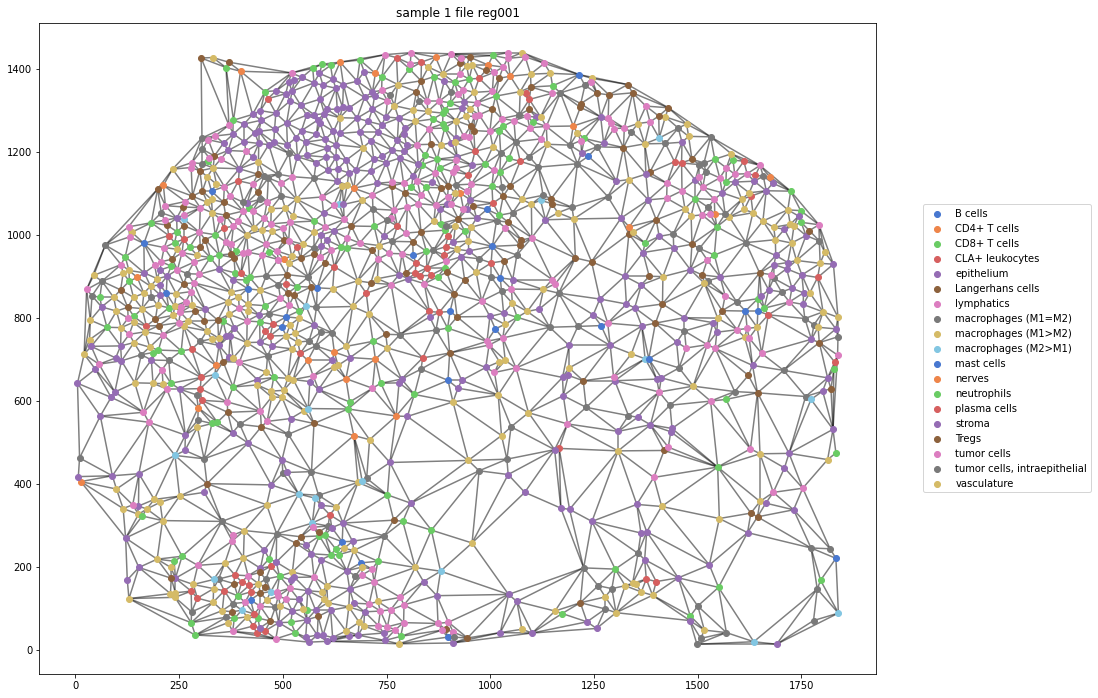

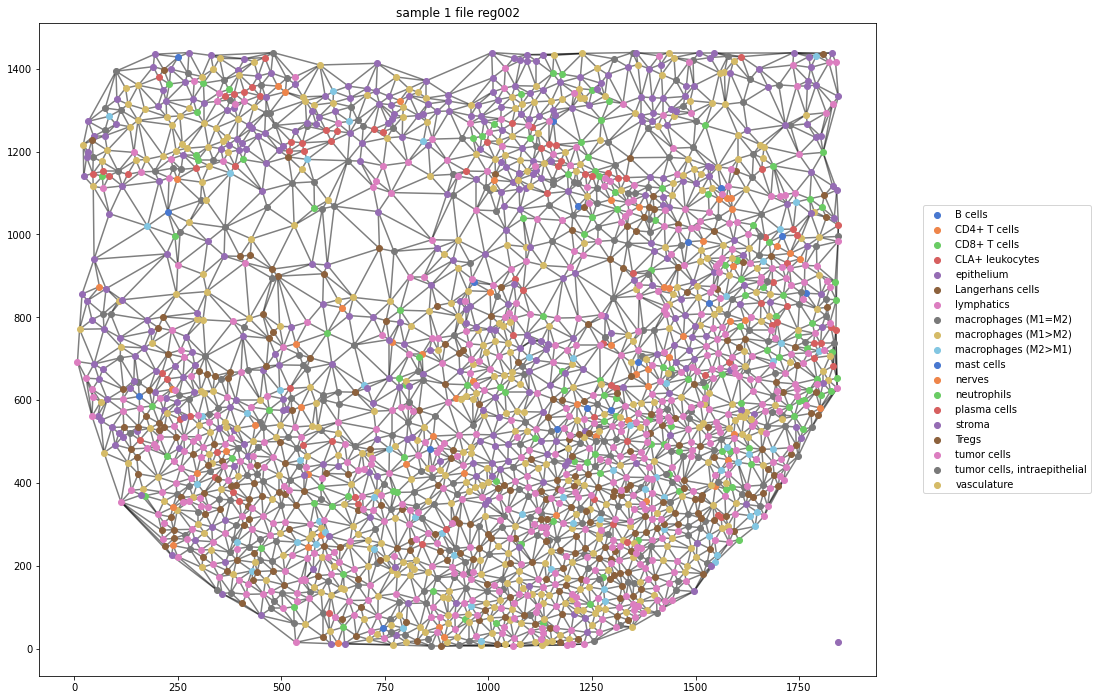

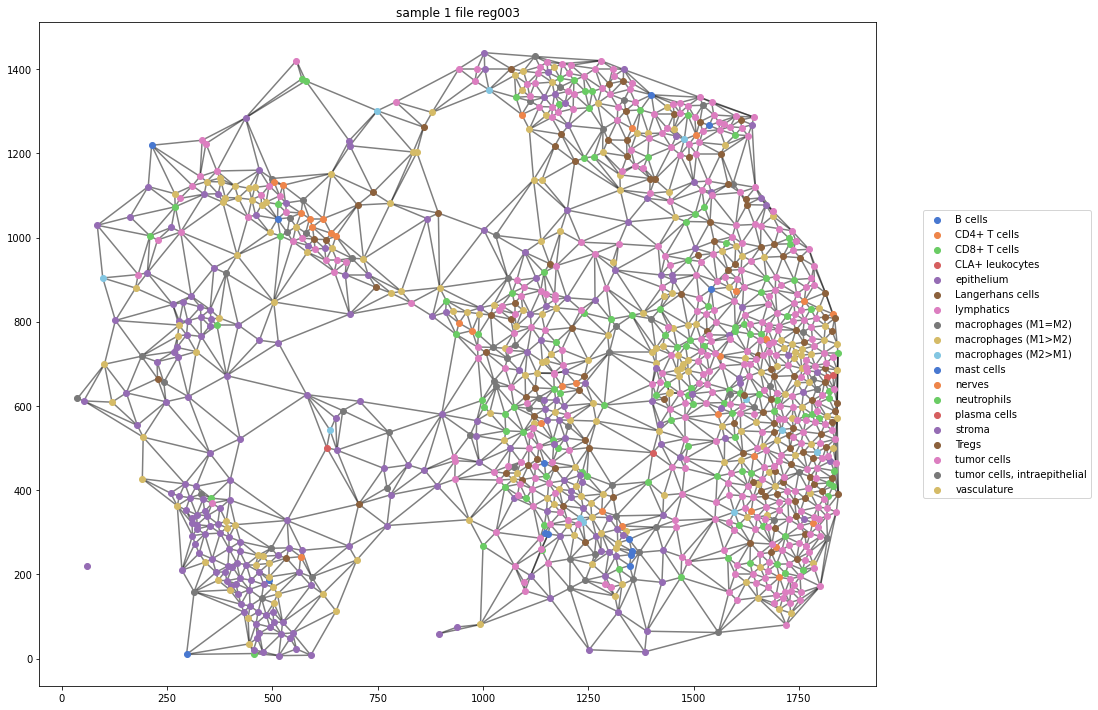

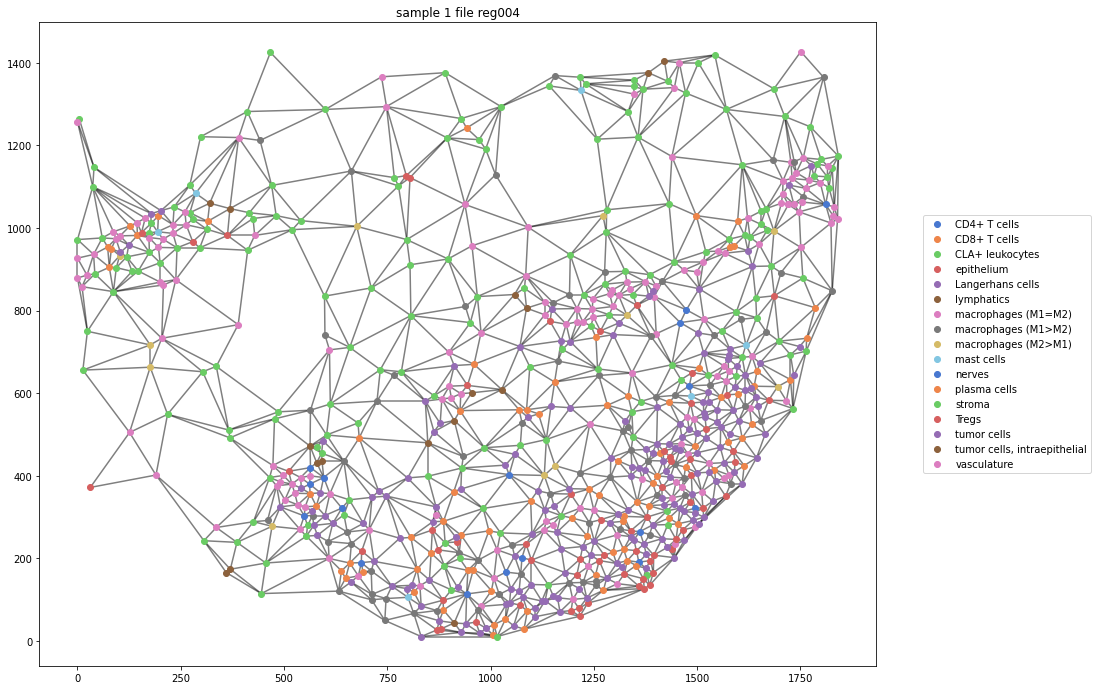

In [11]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[cell_pos_cols].values
    pairs = ty.build_delaunay(coords, trim_dist=200)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    # pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [14]:
processed_dir = Path('../data/processed/CODEX_CTCL')

In [15]:
# Choose optimal distances
save_dir = processed_dir / "pretreatment_samples_networks_xy_solitary-0_choose_distance"

files_dst = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

k_sol = 0 

if RUN_LONG:
    for filename in files_dst:
        print("    processing filename {}".format(filename))
        select_file = obj['FileName'] == filename
        nodes = obj.loc[select_file, all_cols]
        coords = nodes[cell_pos_cols].values
        pairs = ty.build_delaunay(coords, trim_dist=200)
        print("    ", end="")
        if k_sol > 0:
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)
        distances = ty.distance_neighbors(coords, pairs)

        fig, ax = ty.plot_network_distances(
            coords, pairs, distances, labels=nodes['ClusterName'],
            legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)}
            )
        plt.axis('off');
        title = f"network_distances_filename-{filename}"
        plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
        plt.show()

In [16]:
trim_dist = 200 # or 'percentile_size'
k_sol = 0 # or 1, 2, 3, ...
reconst_dir = processed_dir / f"pretreatment_samples_networks_xy_trim_dist-{trim_dist}_solitary-{k_sol}"
save_dir = reconst_dir / "networks_images"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [17]:
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords, pairs, labels=nodes['ClusterName'],
                                      legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [18]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(reconst_dir / 'all_samples-edges.csv', index=False)
else:
    edges_all = pd.read_csv(reconst_dir / 'all_samples-edges.csv')

In [19]:
# or save in separate file for convenience
if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[cell_pos_cols].values
            pairs = ty.build_delaunay(coords, trim_dist=trim_dist)
            print("    ", end="")
            if k_sol > 0:
                pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            edges.to_csv(reconst_dir / f'edges_sample-{filename}.csv', index=False)

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [20]:
# we add attributes to nodes to color network figures
nodes_all = obj[cell_pos_cols].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [21]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
2        1             6             3             5                3   
3        2             2           208           186               14   
4        2           178            20            45                0   
5        1             0             0             1                0   
6        2            83           200           693               15   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
2        1                 0                   0                12     15   
3        2                 0                   2               130     99   
4        2                 0                   0                16      9   
5        1                 0                   0                 5      6   
6        2                 0                   3                95    357   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
2        1                6           5  ...                   71   
3        2             1759          24  ...                  397   
4        2              901           7  ...                  202   
5        1              913           0  ...                   17   
6        2               11         102  ...                  809   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
2        1                        64           3       6            1   
3        2                        39          33      17            0   
4        2                        10          12       9            0   
5        1                         2           2       3            0   
6        2                        43          20       5           26   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
2        1                  4     203          155   
3        2                  4     328          546   
4        2                  4     356          987   
5        1                  1      34            7   
6        2                 35     679         1157   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
2        1                                  2           95  
3        2                                274           86  
4        2                                  5          186  
5        1                                  1           18  
6        2                                 22          255  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [22]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
2        1       0.008392      0.004196      0.006993         0.004196   
3        2       0.000465      0.048327      0.043216         0.003253   
4        2       0.058649      0.006590      0.014827         0.000000   
5        1       0.000000      0.000000      0.000984         0.000000   
...                   ...           ...           ...              ...   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
12       2       0.005878      0.018001      0.039309         0.001837   
13       1       0.001793      0.013625      0.005737         0.002510   
14       2       0.004636      0.014238      0.034437         0.002318   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
2        1          0.000000            0.000000          0.016783  0.020979   
3        2          0.000000            0.000465          0.030204  0.023002   
4        2          0.000000            0.000000          0.005272  0.002965   
5        1          0.000000            0.000000          0.004921  0.005906   
...                      ...                 ...               ...       ...   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
12       2          0.000000            0.000735          0.020206  0.059882   
13       1          0.000000            0.000000          0.019720  0.017928   
14       2          0.000331            0.000000          0.017550  0.207947   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1         0.030897    0.006345  ...             0.150345   
2        1         0.008392    0.006993  ...             0.099301   
3        2         0.408690    0.005576  ...             0.092240   
4        2         0.296870    0.002306  ...             0.066557   
5        1         0.898622    0.000000  ...             0.016732   
...                     ...         ...  ...                  ...   
10       1         0.291503    0.010228  ...             0.125492   
11       1         0.306040    0.004698  ...             0.065101   
12       2         0.316312    0.008450  ...             0.100661   
13       1         0.539261    0.001434  ...             0.058444   
14       2         0.150662    0.006954  ...             0.101656   

CellCluster      macrophages (M2>M1)  mast cells    nerves  neutrophils  \
Patients Groups                                                           
1        1                  0.022897    0.002483  0.009103     0.009931   
2        1                  0.089510    0.004196  0.008392     0.001399   
3        2                  0.009061    0.007667  0.003950     0.000000   
4        2                  0.003295    0.003954  0.002965     0.000000   
5        1                  0.001969    0.001969  0.002953     0.000000   
...                              ...         ...       ...          ...   
10       1                  0.011408    0.007868  0.003147     0.001574   
11       1                  0.029530    0.024832  0.004027     0.000000   
12       2                  0.008450    0.004409  0.005143     0.000735   
13       1                  0.004661    0.004303  0.006095     0.014701   
14       2                  0.006954    0.009272  0.002318     0.000331   

CellCluster      plasma cells    stroma  tumor cells  \
Patients Groups                                        
1        1

#### Descriptive statistics

In [24]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                             
macrophages (M1=M2)  0.212121   0.999961
CD4+ T cells         0.212121   0.999961
tumor cells          0.575175   0.999961
macrophages (M2>M1)  0.575175   0.999961
lymphatics           0.575175   0.999961
...                       ...        ...
neutrophils          0.962704   0.999961
stroma               0.962704   0.999961
DCs, CD11c+          0.999961   0.999961
mast cells           0.999961   0.999961
plasma cells         0.999961   0.999961

[21 rows x 2 columns]

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [25]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [26]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
...                                                      ...        ...
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

[20 rows x 2 columns]

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

In [27]:
prop_types_comp

B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
2        1       0.008392      0.004196      0.006993         0.004196   
3        2       0.000465      0.048327      0.043216         0.003253   
4        2       0.058649      0.006590      0.014827         0.000000   
5        1       0.000000      0.000000      0.000984         0.000000   
...                   ...           ...           ...              ...   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
12       2       0.005878      0.018001      0.039309         0.001837   
13       1       0.001793      0.013625      0.005737         0.002510   
14       2       0.004636      0.014238      0.034437         0.002318   

                 DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
2        1          0.000000            0.000000          0.016783  0.020979   
3        2          0.000000            0.000465          0.030204  0.023002   
4        2          0.000000            0.000000          0.005272  0.002965   
5        1          0.000000            0.000000          0.004921  0.005906   
...                      ...                 ...               ...       ...   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
12       2          0.000000            0.000735          0.020206  0.059882   
13       1          0.000000            0.000000          0.019720  0.017928   
14       2          0.000331            0.000000          0.017550  0.207947   

                 epithelium  lymphatics  ...  \
Patients Groups                          ...   
1        1         0.030897    0.006345  ...   
2        1         0.008392    0.006993  ...   
3        2         0.408690    0.005576  ...   
4        2         0.296870    0.002306  ...   
5        1         0.898622    0.000000  ...   
...                     ...         ...  ...   
10       1         0.291503    0.010228  ...   
11       1         0.306040    0.004698  ...   
12       2         0.316312    0.008450  ...   
13       1         0.539261    0.001434  ...   
14       2         0.150662    0.006954  ...   

                 ((stroma / tumor cells, intraepithelial) / (stroma / vasculature))  \
Patients Groups                                                                       
1        1                                                3.104167                    
2        1                                               47.500000                    
3        2                                                0.313869                    
4        2                                               37.200000                    
5        1                                               18.000000                    
...                                                            ...                    
10       1                                               62.600000                    
11       1                                                8.411765                    
12       2                                                0.905983                    
13       1                                                7.000000                    
14       2                                               18.222222                    

                 ((stroma / tumor cells, intraepithelial) / (tumor cells / tumor cells, intraepithelial))  \
Patients Groups                                                                                             
1        1                             

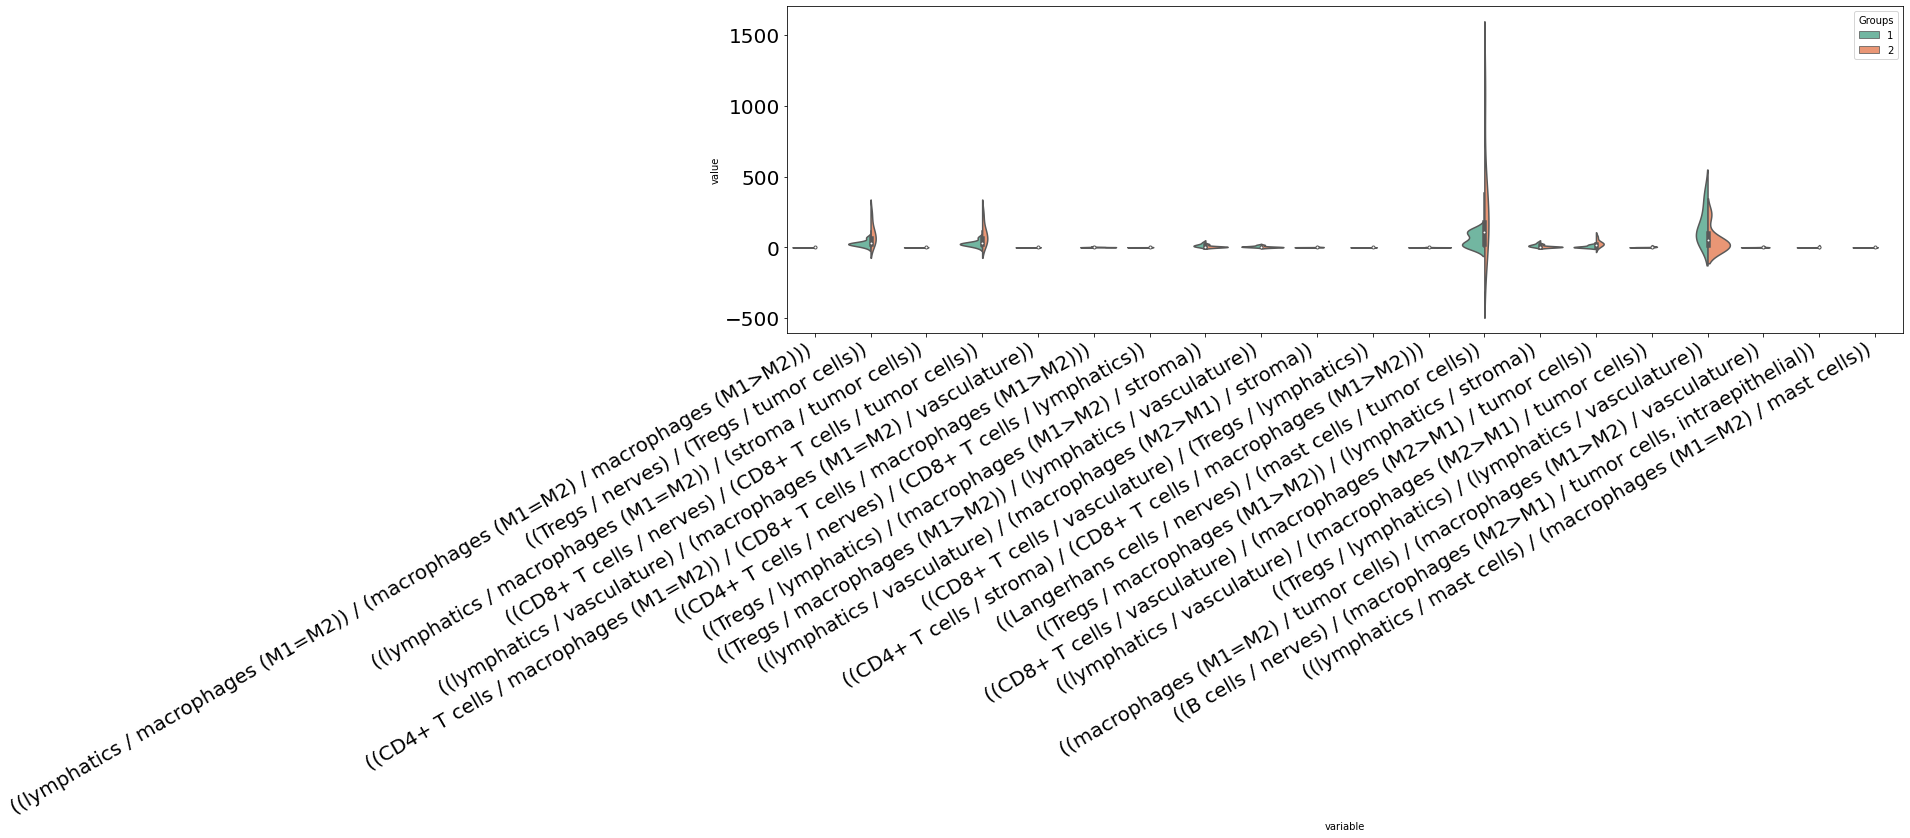

In [29]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

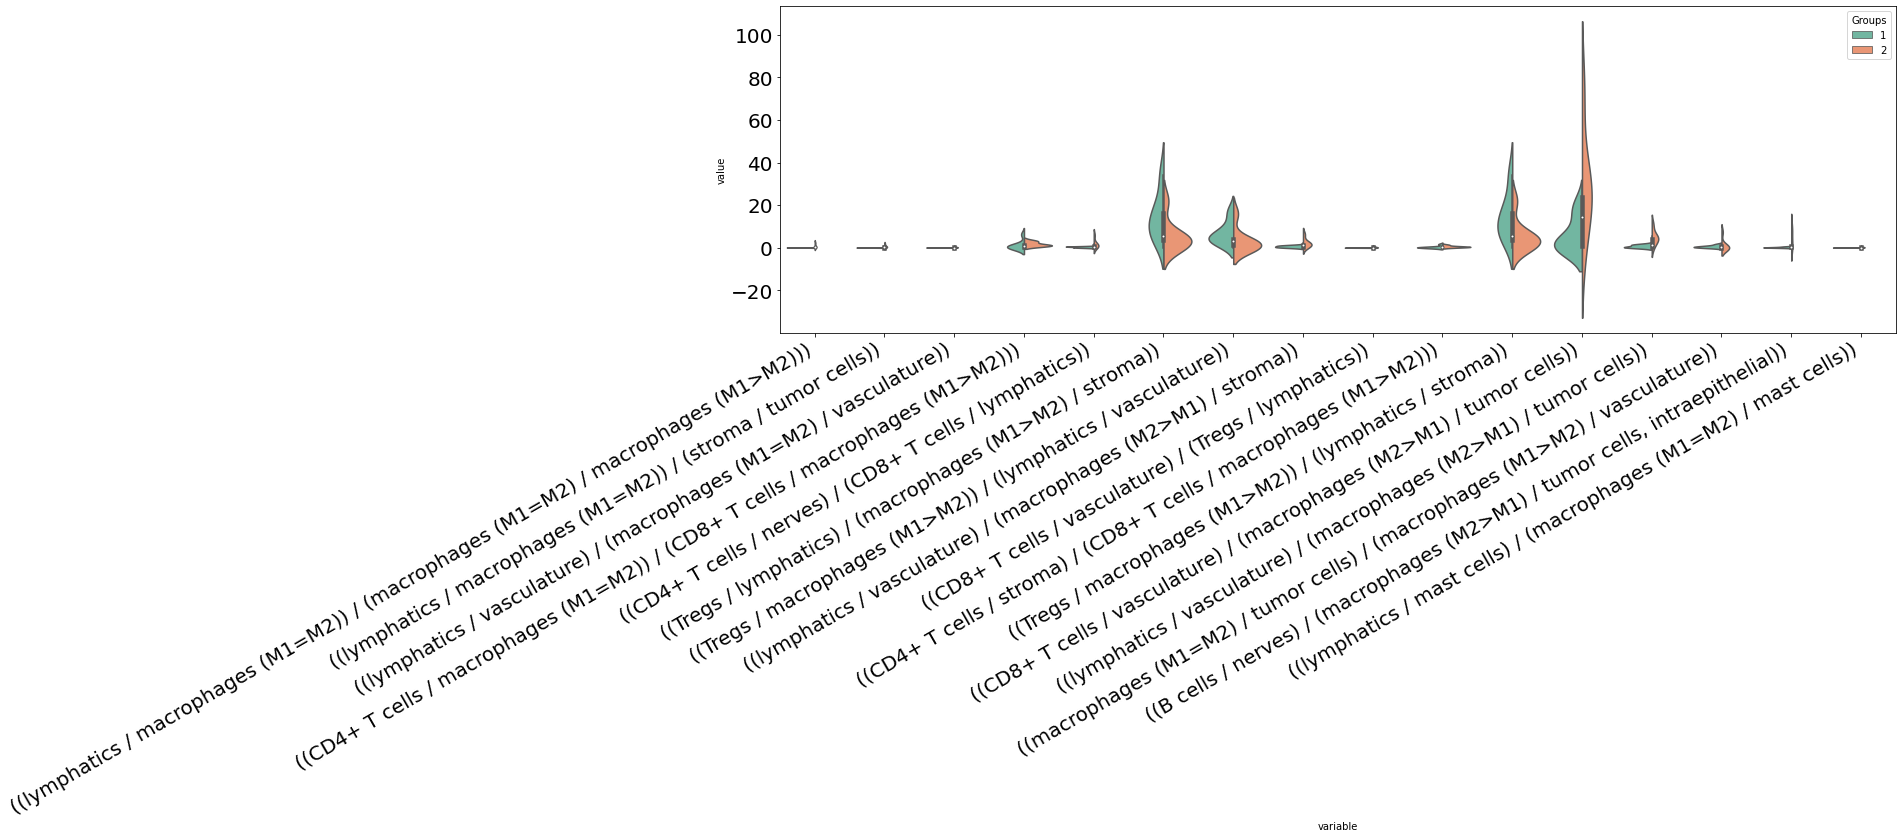

In [30]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

Here we standardize the columns to amake them moe comparable between each other and get a more relevant bi-clustering.

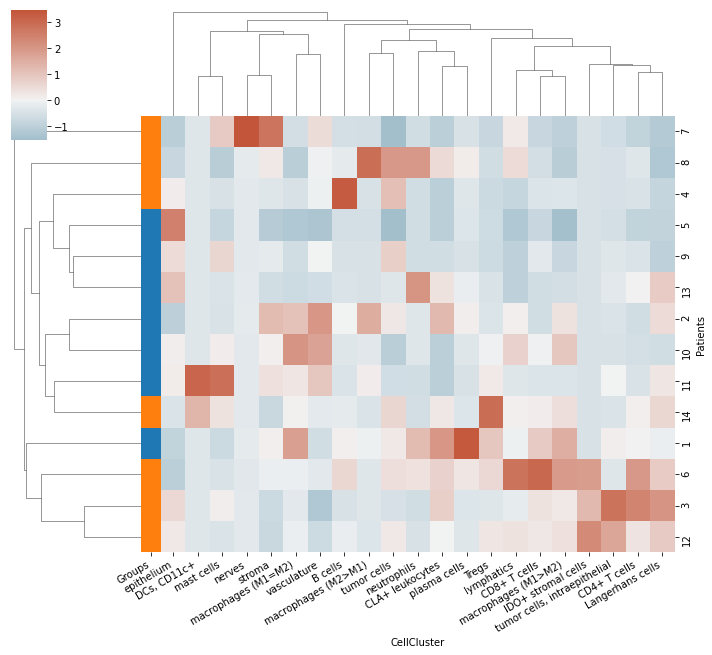

In [31]:
g = mosna.plot_heatmap(
    prop_types.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    )

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [32]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 82218 non finite values
Imputing data


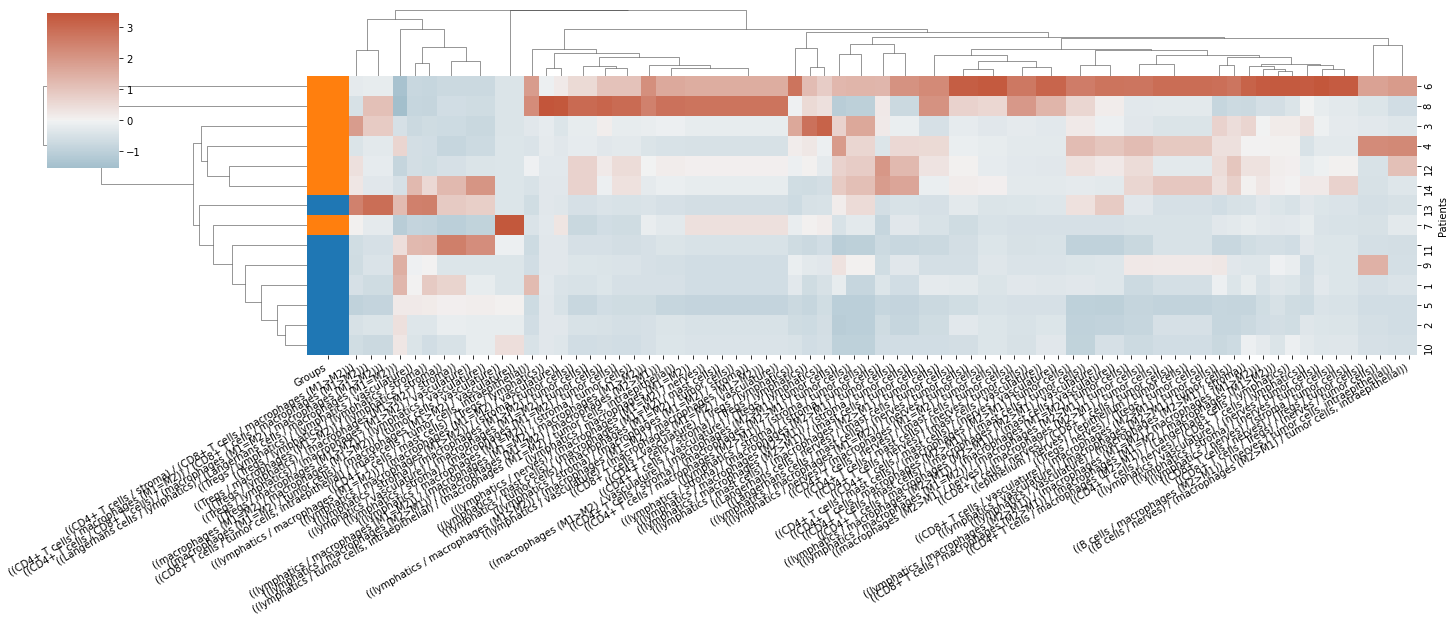

In [33]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    z_score=1,
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.  
We must be careful though: we have computed a lot of composed variables, and selected those who happened to have the best p-values.

#### Stepwise logistic regression

In [34]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.000972217
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.00017107
Add  ((lymphatics / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 3.821e-05


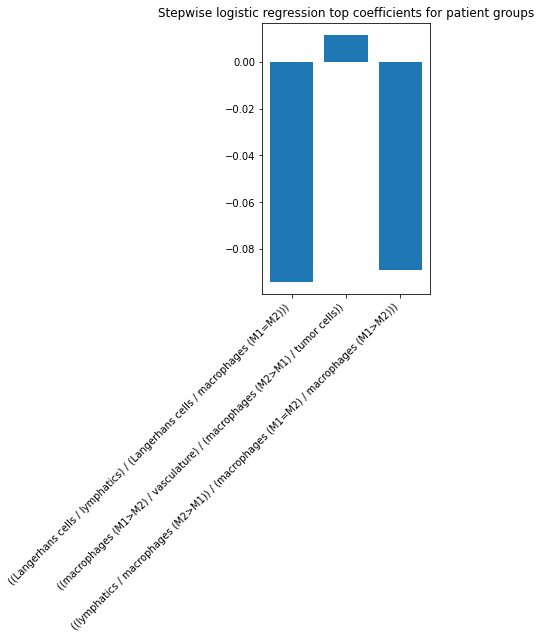

In [35]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [29]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

## Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

###  Assortativity and Mixing Matrix

#### Computation of assortativity

In [23]:
grouping = 'FileName'
n_shuffle = 500
load_dir = reconst_dir
save_dir = load_dir / "assortativity"
filename = save_dir / f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'

if RUN_LONG or not filename.exists():
    start = time()
    net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                    attributes=attribute_uniq, 
                                    groups=obj[grouping], 
                                    n_shuffle=n_shuffle,
                                    parallel_groups=False,
                                    memory_limit='100GB',
                                    save_intermediate_results=False, 
                                    dir_save_interm=save_dir)
    end = time()
    duration = end - start
    print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

    net_stats.index = net_stats['id']
    net_stats.drop(columns=['id'], inplace=True)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net_stats.to_csv(filename)
else:
    net_stats = pd.read_csv(filename, index_col=0)

In [24]:
net_stats

# total  % B cells  % CD4+ T cells  % CD8+ T cells  % CLA+ leukocytes  \
id                                                                              
reg001     1301   0.017679        0.012298        0.082244           0.009224   
reg002     2324   0.004733        0.014630        0.052496           0.003442   
reg006      603   0.009950        0.004975        0.008292           0.004975   
reg035     2053   0.000487        0.007306        0.014613           0.000974   
reg036      618   0.001618        0.006472        0.033981           0.000000   
...         ...        ...             ...             ...                ...   
reg017      558   0.000000        0.000000        0.001792           0.000000   
reg005      112   0.000000        0.000000        0.000000           0.000000   
reg018      458   0.000000        0.000000        0.000000           0.000000   
reg026      257   0.000000        0.000000        0.000000           0.000000   
reg025      144   0.000000        0.000000        0.000000           0.000000   

        % DCs, CD11c+  % epithelium  % IDO+ stromal cells  % Langerhans cells  \
id                                                                              
reg001            0.0      0.069178                   0.0            0.016910   
reg002            0.0      0.009466                   0.0            0.008606   
reg006            0.0      0.006633                   0.0            0.019900   
reg035            0.0      0.500731                   0.0            0.004384   
reg036            0.0      0.021036                   0.0            0.003236   
...               ...           ...                   ...                 ...   
reg017            0.0      0.910394                   0.0            0.005376   
reg005            0.0      0.017857                   0.0            0.000000   
reg018            0.0      0.884279                   0.0            0.004367   
reg026            0.0      0.000000                   0.0            0.003891   
reg025            0.0      0.000000                   0.0            0.000000   

        % lymphatics  ...  vasculature - macrophages (M2>M1) Z  \
id                    ...                                        
reg001      0.011530  ...                            -1.549946   
reg002      0.003442  ...                            -2.386706   
reg006      0.008292  ...                            -2.679097   
reg035      0.000000  ...                            -0.781031   
reg036      0.006472  ...                            -1.144622   
...              ...  ...                                  ...   
reg017      0.000000  ...                            -0.257600   
reg005      0.000000  ...                            -1.281009   
reg018      0.000000  ...                                  NaN   
reg026      0.011673  ...                                  NaN   
reg025      0.000000  ...                                  NaN   

        vasculature - mast cells Z  vasculature - nerves Z  \
id                                                           
reg001                   -0.508612               -0.969886   
reg002                   -0.735220               -1.505281   
reg006                   -0.520487               -0.858949   
reg035                   -1.563830               -0.543025   
reg036                   -1.455334               -1.300634   
...                            ...                     ...   
reg017                   -0.151831               -0.198749   
reg005                   -0.508607                     NaN   
reg018                   -0.169725               -0.261488   
reg026                   -0.954294               -4.473635   
reg025                         NaN               -1.544901   

        vasculature - neutrophils Z  vasculature - plasma cells Z  \
id                                                                  
reg001                    -1.717401                     -2.302747   
reg002                    -

#### Example of Mixing Matrix

In [25]:
sample_id = 'reg001'
# TODO: reimplement the 'RAW' flag
# raw_cols = [x for x in net_stats.columns if x.endswith('RAW') and not x.startswith('assort')]
raw_cols = net_stats.iloc[:, 26:257].columns
z_cols = [x for x in net_stats.columns if x.endswith('Z') and not x.startswith('assort')]

mixmat_raw = mosna.series_to_mixmat(net_stats.loc[sample_id, raw_cols], discard=' RAW').astype(float)
mixmat_z = mosna.series_to_mixmat(net_stats.loc[sample_id, z_cols], discard=' Z').astype(float)
assort_raw = net_stats.loc[sample_id, "assort"]
assort_z = net_stats.loc[sample_id, "assort Z"]

# select_cols = np.logical_and(mixmat_raw.isna(axis=0) == 0, mixmat_z.isna(axis=0) == 0)

Raw assortativity by cell types: 0.97
Z-scored assortativity by cell types: 118.32


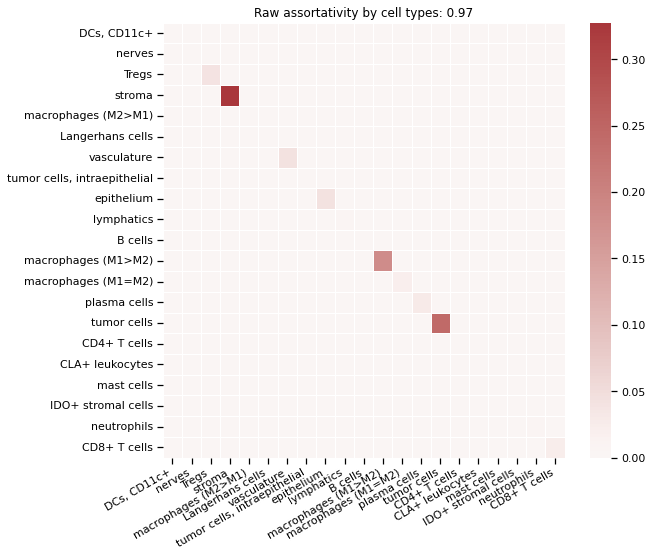

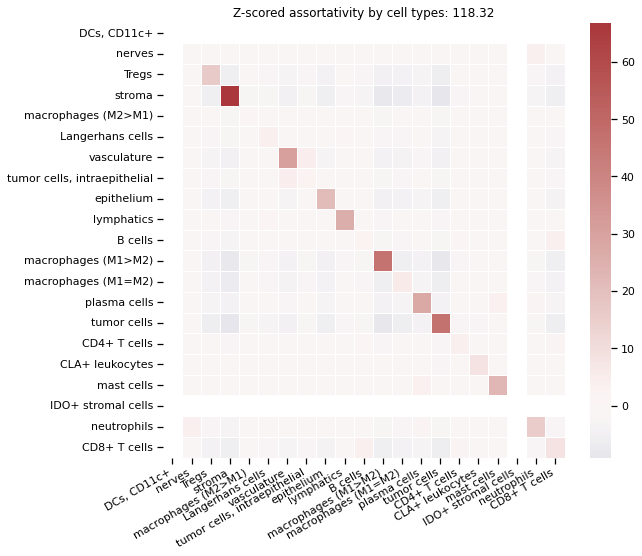

In [26]:
# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, center=0, cmap="vlag", annot=False, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

Raw assortativity by cell types: 0.97
Z-scored assortativity by cell types: 118.32


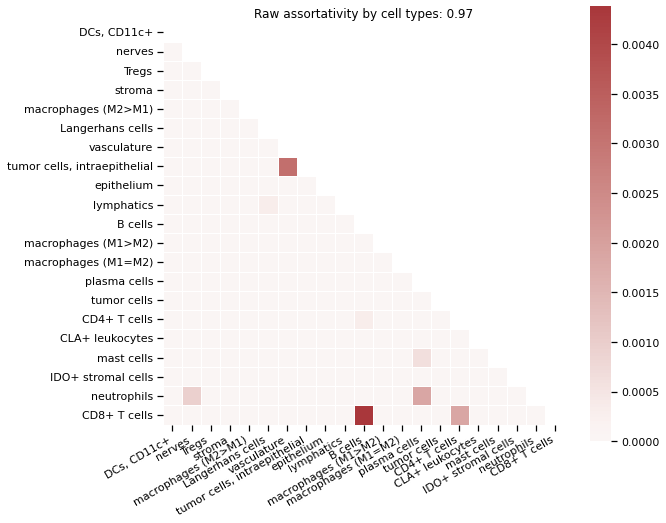

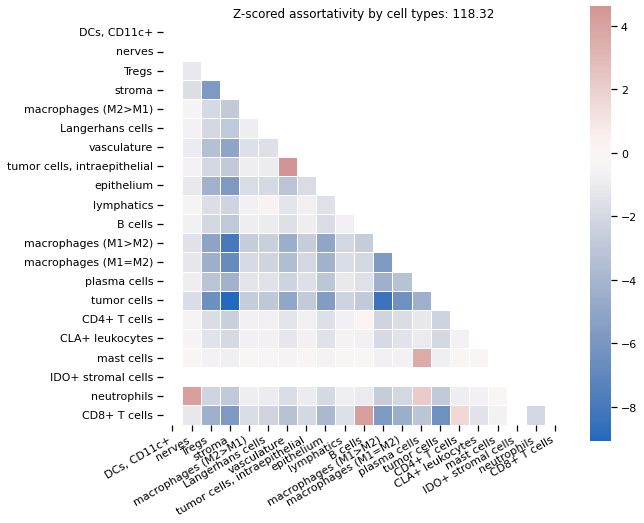

In [27]:
# Hide diagonal
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(mixmat_raw, dtype=bool))

# sns.set_context('talk')
sns.set_context("notebook")
figsize = (9, 8)

title = "Raw assortativity by cell types: {:.2f}".format(assort_raw)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_raw, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.xticks(rotation=30, ha='right', fontsize=20);
# plt.yticks(fontsize=20);
# plt.savefig(save_dir / "assortativity", bbox_inches='tight', facecolor='white')

title = "Z-scored assortativity by cell types: {:.2f}".format(assort_z)
print(title)
f, ax = plt.subplots(figsize=figsize)
sns.heatmap(mixmat_z, mask=mask, center=0, cmap="vlag", annot=False, square=True, linewidths=.5, ax=ax)
ax.set_title(title)
plt.xticks(rotation=30, ha='right');
# plt.savefig(save_dir / "assortativity_z-scored", bbox_inches='tight', facecolor='white')

After removing highly self-assortative cell-types, we can notice that most cell types tend to avoid other cell types in this sample.

#### Assortativity and patients response

In [28]:
z_cols = [x for x in net_stats.columns if x.endswith('Z')]
z_net_stats = net_stats[z_cols]

In [29]:
z_net_stats

assort Z  B cells - B cells Z  CD4+ T cells - B cells Z  \
id                                                                  
reg001  118.322045             2.303197                  0.319617   
reg002  137.208092            -0.231748                  0.942463   
reg006   55.655024            -0.177131                 -0.257600   
reg035   97.992931                  NaN                 -0.135388   
reg036   49.643293                  NaN                 -0.119159   
...            ...                  ...                       ...   
reg017   36.384874                  NaN                       NaN   
reg005   10.062674                  NaN                       NaN   
reg018   29.590299                  NaN                       NaN   
reg026   24.519013                  NaN                       NaN   
reg025   13.905883                  NaN                       NaN   

        CD4+ T cells - CD4+ T cells Z  CD8+ T cells - B cells Z  \
id                                                                
reg001                       3.737300                  4.237213   
reg002                       6.068523                  7.768863   
reg006                      -0.127515                 -0.280056   
reg035                      15.522748                 -0.189234   
reg036                      -0.135388                 -0.243207   
...                               ...                       ...   
reg017                            NaN                       NaN   
reg005                            NaN                       NaN   
reg018                            NaN                       NaN   
reg026                            NaN                       NaN   
reg025                            NaN                       NaN   

        CD8+ T cells - CD4+ T cells Z  CD8+ T cells - CD8+ T cells Z  \
id                                                                     
reg001                       1.592328                       8.319898   
reg002                       2.053927                      28.931623   
reg006                      -0.201949                      12.910897   
reg035                      -0.841861                      23.532646   
reg036                      -0.465250                      10.063439   
...                               ...                            ...   
reg017                            NaN                            NaN   
reg005                            NaN                            NaN   
reg018                            NaN                            NaN   
reg026                            NaN                            NaN   
reg025                            NaN                            NaN   

        CLA+ leukocytes - B cells Z  CLA+ leukocytes - CD4+ T cells Z  \
id                                                                      
reg001                    -0.695376                         -0.598468   
reg002                    -0.291235                         -0.534386   
reg006                    -0.181818                         -0.149983   
reg035                          NaN                         -0.265827   
reg036                          NaN                               NaN   
...                             ...                               ...   
reg017                          NaN                               NaN   
reg005                          NaN                               NaN   
reg018                          NaN                               NaN   
reg026                          NaN                               NaN   
reg025                          NaN                               NaN   

        CLA+ leukocytes - CD8+ T cells Z  ...  \
id                                        ...   
reg001                         -1.417702  ...   
reg002                         -0.949284  ...   
reg006                         -0.217241  ...   
reg035                         -0.303167  ...   
reg036                               NaN  ...   
...       

In [30]:
# Have a look at nan values
for name, value in z_net_stats.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

assort Z                                              0
B cells - B cells Z                                   10
CD4+ T cells - B cells Z                              8
CD4+ T cells - CD4+ T cells Z                         6
CD8+ T cells - B cells Z                              7
CD8+ T cells - CD4+ T cells Z                         6
CD8+ T cells - CD8+ T cells Z                         5
CLA+ leukocytes - B cells Z                           15
CLA+ leukocytes - CD4+ T cells Z                      13
CLA+ leukocytes - CD8+ T cells Z                      13
CLA+ leukocytes - CLA+ leukocytes Z                   15
DCs, CD11c+ - B cells Z                               28
DCs, CD11c+ - CD4+ T cells Z                          27
DCs, CD11c+ - CD8+ T cells Z                          27
DCs, CD11c+ - CLA+ leukocytes Z                       28
DCs, CD11c+ - DCs, CD11c+ Z                           29
epithelium - B cells Z                                7
epithelium - CD4+ T cells Z           

(array([31., 45., 53., 21., 29., 11.,  1.,  0., 19., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

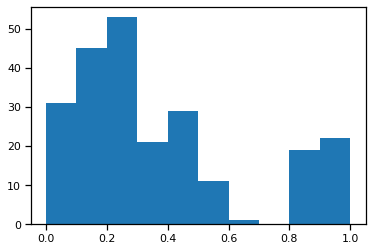

In [31]:
plt.hist(z_net_stats.isna().sum(axis=0) / z_net_stats.shape[0])

In [32]:
z_net_stats.isna().sum(axis=1) / z_net_stats.shape[1]

id
reg001    0.176724
reg002    0.176724
reg006    0.181034
reg035    0.422414
reg036    0.482759
            ...   
reg017    0.646552
reg005    0.844828
reg018    0.724138
reg026    0.810345
reg025    0.909483
Length: 29, dtype: float64

There are some nan values due to interactions between rare cell types that never happened.  
Can can have a first look at the sample, but it would be more informative to have a look at samples before therapy, grouping them per patient.

In [33]:
# we need to clean-up data for further analyses and visualizations
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='mixed',
    thresh=0.9,
    )
print("Final z_net_stats shape:", z_net_stats_cleaned.shape)

There are 2422 non finite values
Imputing data
Final z_net_stats shape: (29, 210)


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan


In [34]:
# try dropping first observations with too many NaN, then columns:
print("Original z_net_stats shape:", z_net_stats.shape)
z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats, 
    method='drop',
    thresh=0.8,
    axis=1,
    )
unselected = ~select_finite
print(f"There are {unselected.sum()} observations discarded")
print("Intermediate z_net_stats shape:", z_net_stats_cleaned.shape)

z_net_stats_cleaned, select_finite = mosna.clean_data(
    z_net_stats_cleaned, 
    method='mixed',
    thresh=0.7,
    axis=0,
    )
unselected = ~select_finite
print(f"There are {unselected.sum()} variables discarded")
print("Final z_net_stats shape:", z_net_stats_cleaned.shape)

Original z_net_stats shape: (29, 232)
There are 2422 non finite values
There are 3 observations discarded
Intermediate z_net_stats shape: (26, 232)
There are 1827 non finite values
Imputing data
There are 41 variables discarded
Final z_net_stats shape: (26, 191)


/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan
/home/alexis/Postdoc_CRCT/Projects/mosna/mosna/mosna.py:1384: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[to_nan] = np.nan


Let's add information about patients' group and time of biopsy

In [35]:
if 'FileName' in status.columns:
    status.index = status['FileName']
    status.drop(columns=['FileName'], inplace=True)
    status.index.name = 'id'
# status.sort_values('Spots')
status

Patients  Groups  Spots
id                             
reg001         1       1      1
reg002         1       1      2
reg005         2       1      5
reg006         2       1      6
reg009         3       2      9
...          ...     ...    ...
reg046        12       2     46
reg051        13       1     51
reg052        13       1     52
reg057        14       2     57
reg058        14       2     58

[29 rows x 3 columns]

In [36]:
# samples 25, 36, 37, 40, 44 are missing
# pd.set_option('display.max_rows', 10)
# reg026 and reg044 not in biopsies
z_net_stats_cleaned = pd.concat([status, z_net_stats_cleaned], axis=1, join='inner')#.sort_values('Spots')
# z_net_stats_cleaned.drop(columns=['Spots'], inplace=True)
z_net_stats_cleaned

Patients  Groups  Spots    assort Z  B cells - B cells Z  \
id                                                                 
reg001         1       1      1  118.322045             2.303197   
reg002         1       1      2  137.208092            -0.231748   
reg006         2       1      6   55.655024            -0.177131   
reg009         3       2      9  147.886215             0.569049   
reg010         3       2     10  129.346618             6.780520   
...          ...     ...    ...         ...                  ...   
reg046        12       2     46   58.320174            -0.127515   
reg051        13       1     51   73.188113            -0.044766   
reg052        13       1     52  104.690865            -0.089803   
reg057        14       2     57   67.795311             6.120583   
reg058        14       2     58  119.864610            -0.163383   

        CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
id                                                                
reg001                  0.319617                       3.737300   
reg002                  0.942463                       6.068523   
reg006                 -0.257600                      -0.127515   
reg009                 -0.553307                      31.125710   
reg010                 -0.236597                      18.643403   
...                          ...                            ...   
reg046                  2.069256                      14.043893   
reg051                  2.821890                       8.566951   
reg052                 -0.312898                      13.080265   
reg057                  5.854129                      13.788085   
reg058                 -0.452958                       5.909709   

        CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
id                                                                
reg001                  4.237213                       1.592328   
reg002                  7.768863                       2.053927   
reg006                 -0.280056                      -0.201949   
reg009                 -0.529696                      -4.215097   
reg010                 -0.785932                      -2.936095   
...                          ...                            ...   
reg046                 -0.536480                      -0.975387   
reg051                 -0.163383                      -0.647322   
reg052                 -0.182989                      -0.425656   
reg057                 -0.831624                      -1.605719   
reg058                 -0.597786                      -0.833593   

        CD8+ T cells - CD8+ T cells Z  ...  \
id                                     ...   
reg001                       8.319898  ...   
reg002                      28.931623  ...   
reg006                      12.910897  ...   
reg009                      30.693043  ...   
reg010                      34.715332  ...   
...                               ...  ...   
reg046                       2.046266  ...   
reg051                       8.224060  ...   
reg052                       6.667424  ...   
reg057                      14.802393  ...   
reg058                       9.905430  ...   

        vasculature - macrophages (M2>M1) Z  vasculature - mast cells Z  \
id                                                                        
reg001                            -1.549946                   -0.508612   
reg002                            -2.386706                   -0.735220   
reg006                            -2.679097                   -0.520487   
reg009                            -0.836447                   -0.658226   
reg010                            -1.109047                   -1.168038   
...                                     ...                         ...   
reg046                            -0.681015                   -0.761447   
reg051                            -1.112099                   -1.256780   
reg052                        

In [37]:
pvals = mosna.find_DE_markers(z_net_stats_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [38]:
pvals.head(20)

pval  pval_corr
CD8+ T cells - B cells Z                            0.000062   0.011999
vasculature - vasculature Z                         0.000500   0.047997
tumor cells - macrophages (M1>M2) Z                 0.002875   0.061330
CLA+ leukocytes - CD8+ T cells Z                    0.002875   0.061330
tumor cells - lymphatics Z                          0.002875   0.061330
...                                                      ...        ...
lymphatics - CD4+ T cells Z                         0.012649   0.127824
tumor cells, intraepithelial - tumor cells, int...  0.012649   0.127824
macrophages (M1>M2) - CLA+ leukocytes Z             0.012649   0.127824
CLA+ leukocytes - CD4+ T cells Z                    0.012649   0.127824
macrophages (M2>M1) - CD4+ T cells Z                0.044272   0.274204

[20 rows x 2 columns]

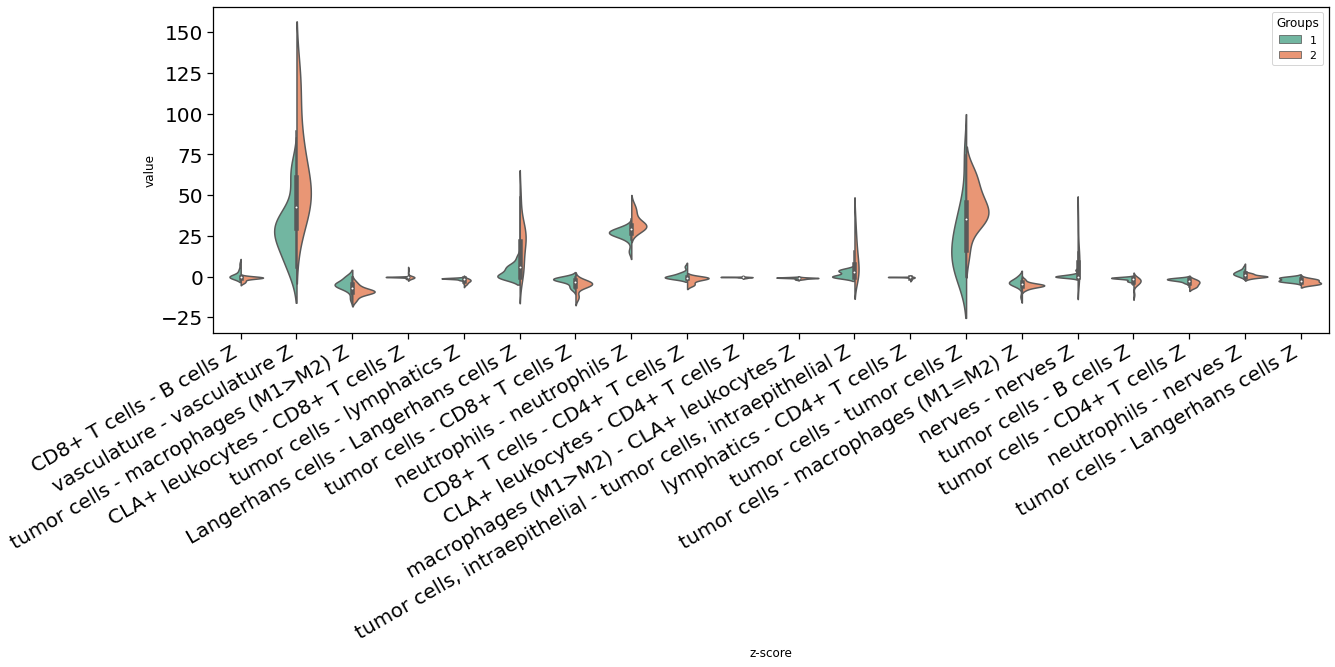

In [39]:
reload(mosna)
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

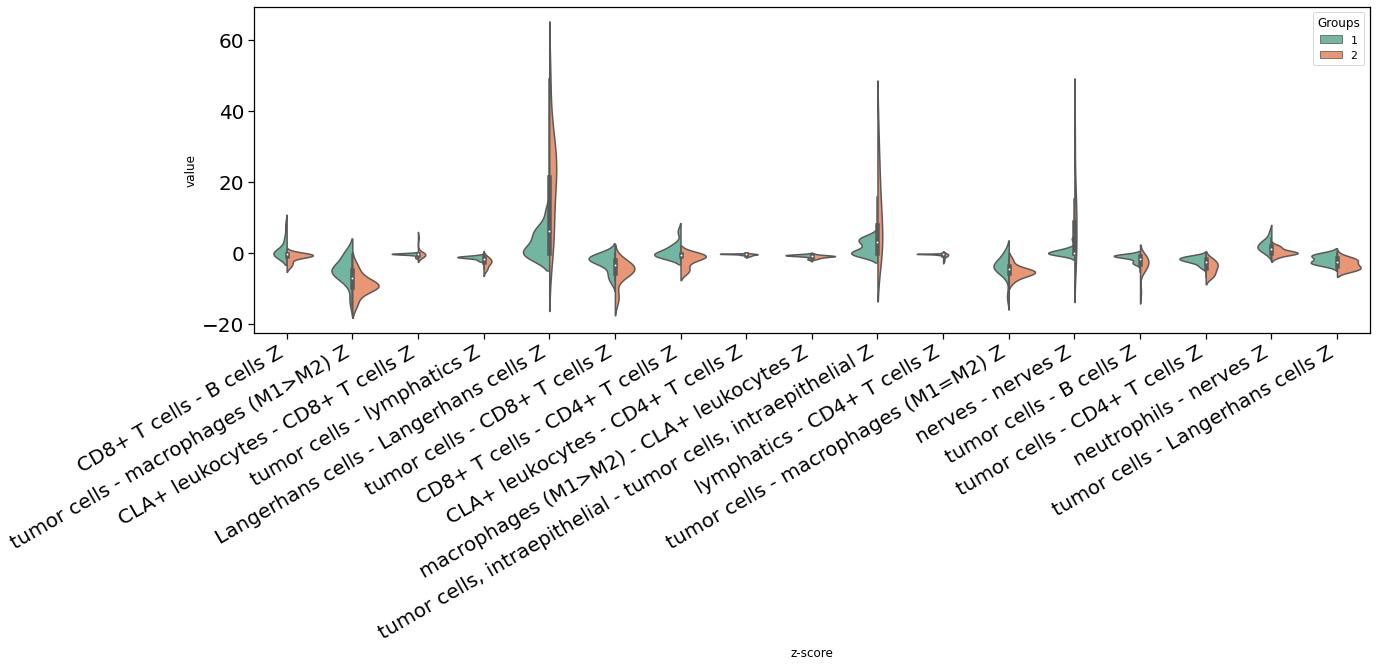

In [40]:
exclude_vars = [
    'assort Z',
    'vasculature - vasculature Z',
    'neutrophils - neutrophils Z',
    'tumor cells - tumor cells Z',
]
fig, ax = mosna.plot_distrib_groups(
    z_net_stats_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    exclude_vars=exclude_vars,
    )

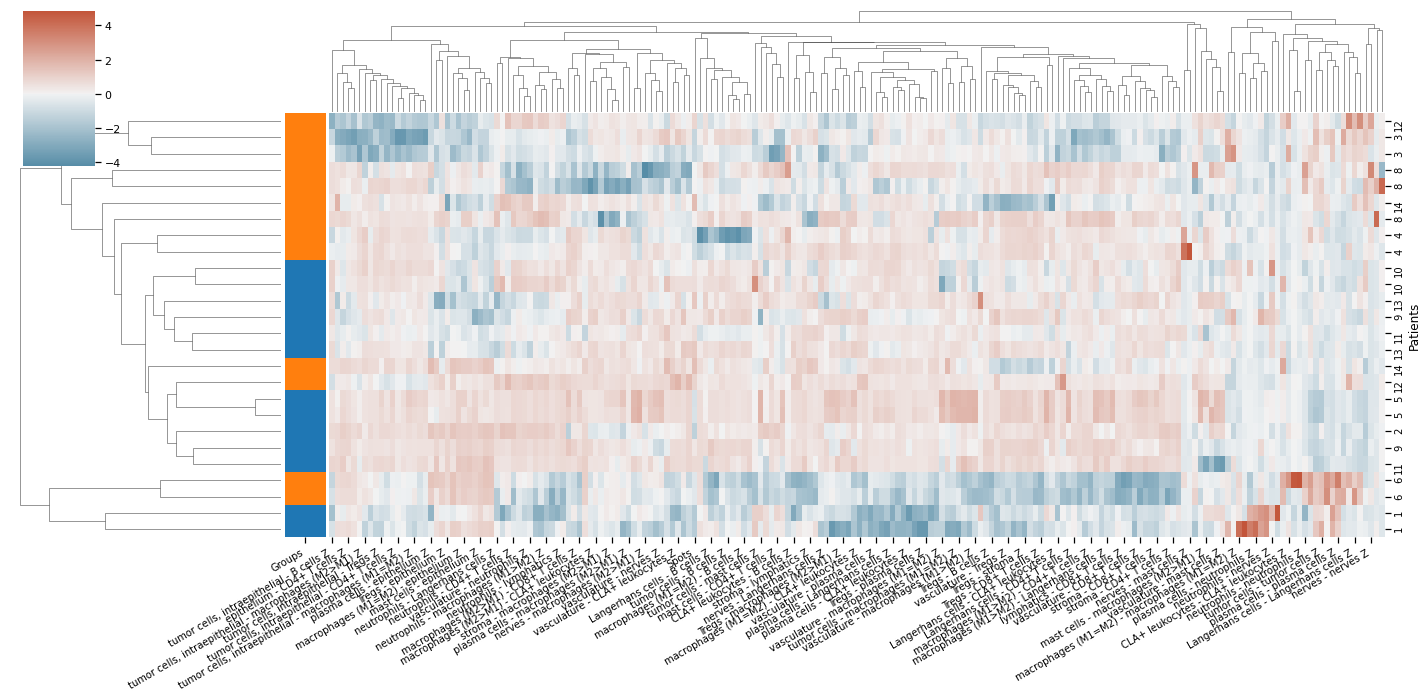

In [41]:
mosna.plot_heatmap(
    z_net_stats_cleaned, 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    skip_cols=['assort Z'],
    )

Samples are a bit clustered into consistent response groups, but it's not incredible.  
We also need to aggregate samples per patient and time of biopsy, that may help us correcting nan values and have more variables, and hopefully better clusters.

#### Samples aggregation per patient and time point.

In [42]:
z_net_stats = pd.concat([status, z_net_stats], axis=1, join='inner')#.sort_values('Spots')
# z_net_stats.drop(columns=['Spots'], inplace=True)

In [43]:
# good news: the mean of aggregated data already ignores nans
z_net_stats_agg = z_net_stats.groupby(['Patients', 'Groups']).mean()
z_net_stats_agg

Spots    assort Z  B cells - B cells Z  \
Patients Groups                                           
1        1         1.5  127.765069             1.035724   
2        1         5.5   32.858849            -0.177131   
3        2         9.5  138.616416                  NaN   
4        2        13.5   93.038644            45.875689   
5        1        17.5   32.987587                  NaN   
...                ...         ...                  ...   
10       1        39.5   92.129112            -0.089098   
11       1        41.5   57.383863            -0.044766   
12       2        45.5   92.459723             1.679651   
13       1        51.5   88.939489            -0.067284   
14       2        57.5   93.829961             2.978600   

                 CD4+ T cells - B cells Z  CD4+ T cells - CD4+ T cells Z  \
Patients Groups                                                            
1        1                       0.631040                       4.902911   
2        1                      -0.257600                      -0.127515   
3        2                      -0.553307                      24.884557   
4        2                      -0.469180                       1.022058   
5        1                            NaN                            NaN   
...                                   ...                            ...   
10       1                       2.411048                       2.199037   
11       1                            NaN                      13.915332   
12       2                       2.815254                      15.350211   
13       1                       1.254496                      10.823608   
14       2                       2.700585                       9.848897   

                 CD8+ T cells - B cells Z  CD8+ T cells - CD4+ T cells Z  \
Patients Groups                                                            
1        1                       6.003038                       1.823127   
2        1                      -0.280056                      -0.201949   
3        2                      -0.529696                      -3.575596   
4        2                      -1.638282                      -0.664937   
5        1                            NaN                            NaN   
...                                   ...                            ...   
10       1                       1.320280                       3.977240   
11       1                      -0.135388                      -0.600945   
12       2                      -0.775285                      -1.416192   
13       1                      -0.173186                      -0.536489   
14       2                      -0.714705                      -1.219656   

                 CD8+ T cells - CD8+ T cells Z  CLA+ leukocytes - B cells Z  \
Patients Groups                                                               
1        1                           18.625760                    -0.493305   
2        1                           12.910897                    -0.181818   
3        2                           32.704188                    -0.119159   
4        2                            8.211085                          NaN   
5        1                                 NaN                          NaN   
...                                        ...                          ...   
10       1                           16.262644                          NaN   
11       1                            5.024705                          NaN   
12       2                            3.875523                    -0.158009   
13       1                            7.445742                    -0.132650   
14       2                           12.353911                    -0.189032   

                 CLA+ leukocytes - CD4+ T cells Z  ...  \
Patients Groups                                    ...   
1        1                              -0.566427  ...   
2        1                              -0.149983  ...   
3        2 

In [44]:
# Have a look at nan values
for name, value in z_net_stats_agg.isna().sum().iteritems():
    print(name, ' ' * (52- len(name)), value)

Spots                                                 0
assort Z                                              0
B cells - B cells Z                                   4
CD4+ T cells - B cells Z                              3
CD4+ T cells - CD4+ T cells Z                         2
CD8+ T cells - B cells Z                              2
CD8+ T cells - CD4+ T cells Z                         2
CD8+ T cells - CD8+ T cells Z                         2
CLA+ leukocytes - B cells Z                           6
CLA+ leukocytes - CD4+ T cells Z                      5
CLA+ leukocytes - CD8+ T cells Z                      5
CLA+ leukocytes - CLA+ leukocytes Z                   6
DCs, CD11c+ - B cells Z                               13
DCs, CD11c+ - CD4+ T cells Z                          12
DCs, CD11c+ - CD8+ T cells Z                          12
DCs, CD11c+ - CLA+ leukocytes Z                       13
DCs, CD11c+ - DCs, CD11c+ Z                           14
epithelium - B cells Z                     

(array([95., 40., 19., 15., 21.,  1.,  1., 17., 17.,  7.]),
 array([0.        , 0.04827586, 0.09655172, 0.14482759, 0.19310345,
        0.24137931, 0.28965517, 0.33793103, 0.3862069 , 0.43448276,
        0.48275862]),
 <BarContainer object of 10 artists>)

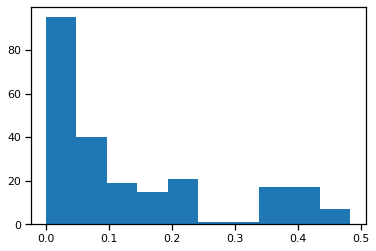

In [45]:
plt.hist(z_net_stats_agg.isna().sum(axis=0) / z_net_stats.shape[0])

In [46]:
pd.set_option('display.max_rows', 20)
z_net_stats_agg.isna().sum(axis=1) / z_net_stats_agg.shape[1]

Patients  Groups
1         1         0.175966
2         1         0.180258
3         2         0.188841
4         2         0.334764
5         1         0.592275
6         2         0.094421
7         2         0.806867
8         2         0.184549
9         1         0.356223
10        1         0.257511
11        1         0.347639
12        2         0.094421
13        1         0.175966
14        2         0.107296
dtype: float64

In [47]:
z_net_agg_cleaned, select_finite = mosna.clean_data(
    z_net_stats_agg, 
    method='mixed',
    thresh=0.9,
    )

There are 908 non finite values
Imputing data


In [48]:
pvals = mosna.find_DE_markers(z_net_agg_cleaned.iloc[:, 1:], group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [49]:
pvals.head(20)

pval  pval_corr
neutrophils - neutrophils Z                         0.000583   0.131119
tumor cells, intraepithelial - tumor cells, int...  0.008159   0.397727
CD8+ T cells - B cells Z                            0.008159   0.397727
tumor cells, intraepithelial - B cells Z            0.008159   0.397727
assort Z                                            0.053030   0.397727
lymphatics - CD4+ T cells Z                         0.053030   0.397727
lymphatics - DCs, CD11c+ Z                          0.053030   0.397727
macrophages (M1=M2) - DCs, CD11c+ Z                 0.053030   0.397727
macrophages (M1>M2) - DCs, CD11c+ Z                 0.053030   0.397727
macrophages (M2>M1) - DCs, CD11c+ Z                 0.053030   0.397727
mast cells - DCs, CD11c+ Z                          0.053030   0.397727
nerves - DCs, CD11c+ Z                              0.053030   0.397727
nerves - nerves Z                                   0.053030   0.397727
stroma - DCs, CD11c+ Z                              0.053030   0.397727
Langerhans cells - Langerhans cells Z               0.053030   0.397727
Tregs - DCs, CD11c+ Z                               0.053030   0.397727
tumor cells - CD4+ T cells Z                        0.053030   0.397727
tumor cells - DCs, CD11c+ Z                         0.053030   0.397727
tumor cells - lymphatics Z                          0.053030   0.397727
tumor cells - macrophages (M1>M2) Z                 0.053030   0.397727

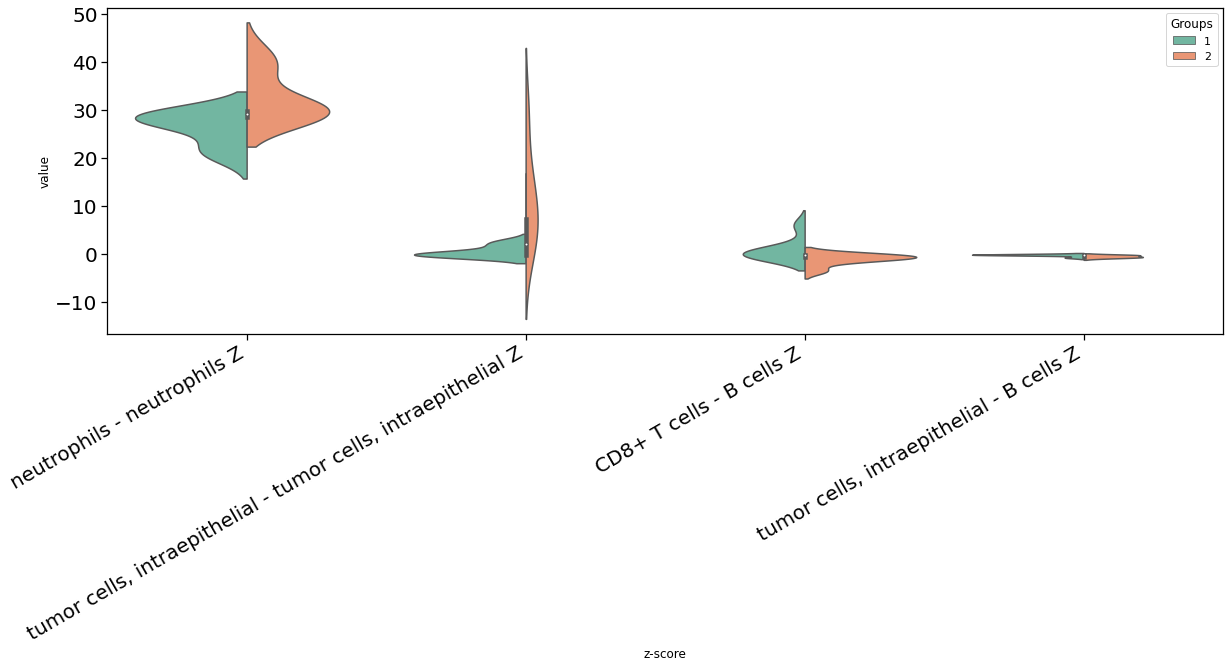

In [50]:
fig, ax = mosna.plot_distrib_groups(
    z_net_agg_cleaned, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    var_name='z-score',
    )

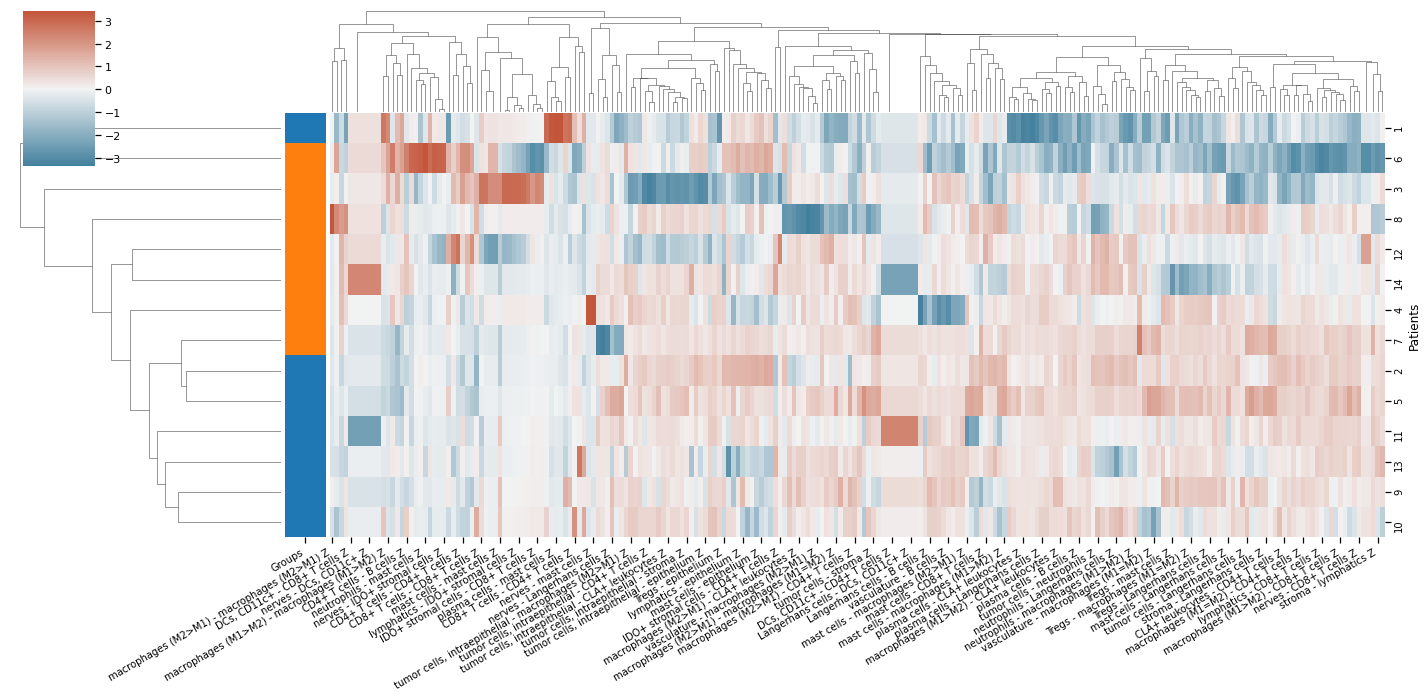

In [51]:
mosna.plot_heatmap(
    z_net_agg_cleaned.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

#### Logistic regression on interaction coefficients

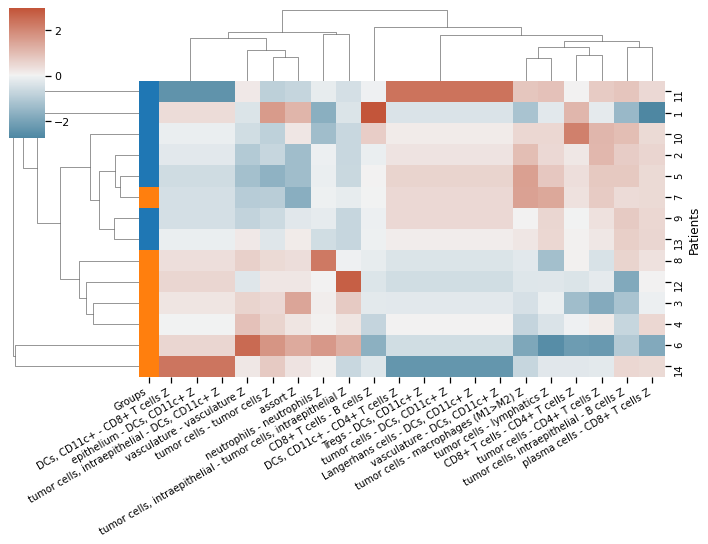

In [52]:
# use the most statistically relevant variable separating groups
# Note: that's to have a clue, do not use this method for real,
# it's a tautology!

nb_vars = np.sum(pvals['pval'] <= 0.06)
nb_vars = min(nb_vars, 20)
marker_vars = pvals.sort_values(by='pval', ascending=True).head(nb_vars).index.tolist()

mosna.plot_heatmap(
    z_net_agg_cleaned[marker_vars].reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    )

### Marker-positive cells interactions

We can also compute the mixing matrix and assortativity between marker-positive cells.

## Cellular neighborhoods

The mixing matrix and assortativity give us information about the global network organization.  
Here we will see how to use the *Neighbors Aggregation Statistics* method to find local "cellular communities", or "neighborhoods", or "niches", that can be relevant to understand disease progression or response to therapies.  

### On cell types

First order neighbors, mean and std

In [50]:
order = 1
var_type = 'cell-types'
stat_names = 'mean-std'
aggreg_vars = cell_type_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [51]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

In [52]:
# attrib_all = obj[cell_type_cols]
X = obj[aggreg_vars].values
edges_all = pd.read_csv(reconst_dir/ 'sample_all-edges.csv')
pairs = edges_all.values

In [53]:
filename = nas_dir / f'aggregation_statistics.csv'

if filename.exists():
    var_aggreg = pd.read_csv(filename)
else:
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(filename, index=False)

In [54]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer = umap.UMAP(
    random_state=0,
    n_neighbors=n_neighbors,
    metric=metric,
    min_dist=min_dist,
    # we don't modify the other parameters
    # spread=1.0,
    # set_op_mix_ratio=1.0,
    # local_connectivity=1.0,
    # repulsion_strength=1.0,
    # negative_sample_rate=5,
    # transform_queue_size=4.0,
    )
embedding = reducer.fit_transform(var_aggreg)
reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
# save reduced coordinates
np.save(nas_dir / (reducer_name + '.npy'), embedding, allow_pickle=False, fix_imports=False)
# save the reducer object
joblib.dump(reducer, nas_dir / (reducer_name + '.pkl'))
embedding.shape

/home/alexis/.pyenv/versions/3.8.10/envs/spatial-networks/lib/python3.8/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


(117170, 2)

In [47]:
joblib.dump(reducer, str(nas_dir / (reducer_name + '.pkl')))

['../data/processed/CODEX_CTCL/all_samples_networks_xy_trim_dist-percentile_size_solitary-0/nas_on-cell-types_stats-mean-std_order-1/reducer-umap_nneigh-70_metric-euclidean_min_dist-0.0.pkl']

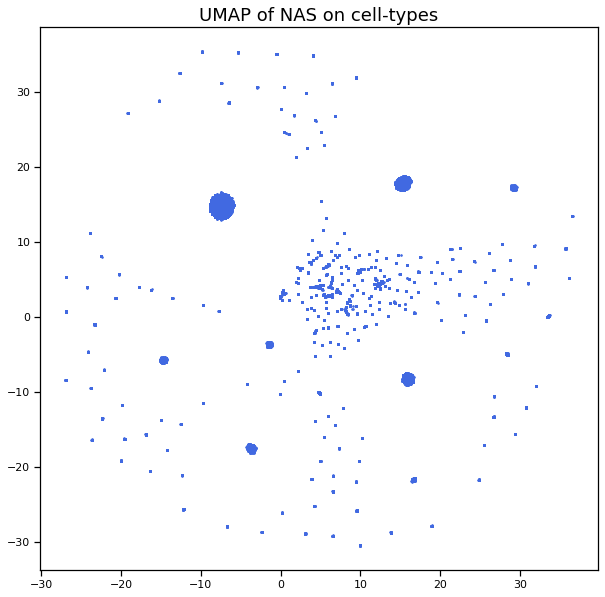

In [48]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Screen NAS parameters

In [ ]:
from importlib import reload
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
parallel_dim = 'max'
parallel_clustering = 4
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'
save_dir = 'test-parallel'

mosna.screen_nas_parameters(X, pairs, markers, orders, dim_clusts, min_cluster_sizes, processed_dir, save_dir=save_dir, soft_clustering=True, 
                            opt_str=opt_str, parallel_dim=parallel_dim, parallel_clustering=parallel_clustering, memory_limit='800GB')


#### Clusters visualization

dim_clust: 2
    min_cluster_size: 100


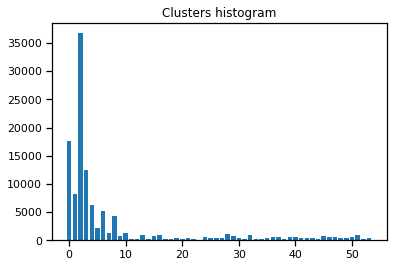

No handles with labels found to put in legend.


        sample: 1


In [188]:
reload(mosna)

orders = [1]
dim_clusts = [2, 3, 4, 5, 6, 7, 8, 9]
min_cluster_sizes = [100, 250, 500, 750, 1000]
processed_dir = Path('../data/processed/CODEX_CTCL')
opt_str = '_samples-all_stat-mean-std'

mosna.plot_screened_parameters(obj, cell_pos_cols, cell_type_cols, orders, dim_clusts, processed_dir,
                               min_cluster_sizes, all_edges='all_samples_networks', sampling=False, var_type=None, 
                               downsample=False, aggreg_dir=None, load_dir=None, save_dir=None, opt_str=opt_str)

### On markers

In [97]:
order = 1
var_type = 'markers'
stat_names = 'mean'
aggreg_vars = marker_cols

# For UMAP visualization
marker = '.'
size_points = 10

In [98]:
nas_dir = reconst_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

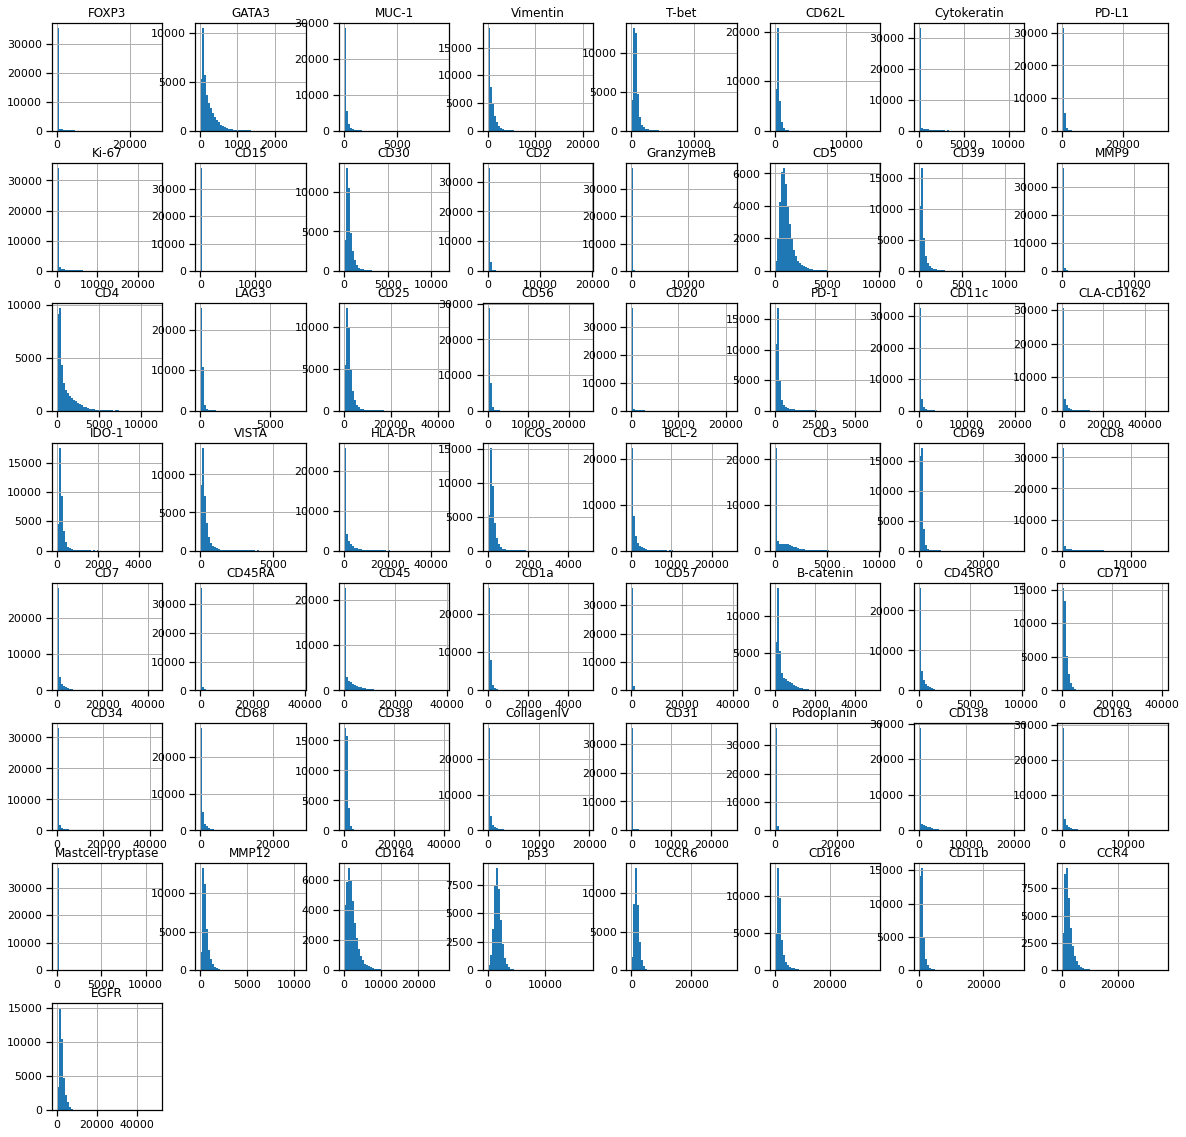

In [99]:
obj[aggreg_vars].hist(bins=50, figsize=(20, 20));

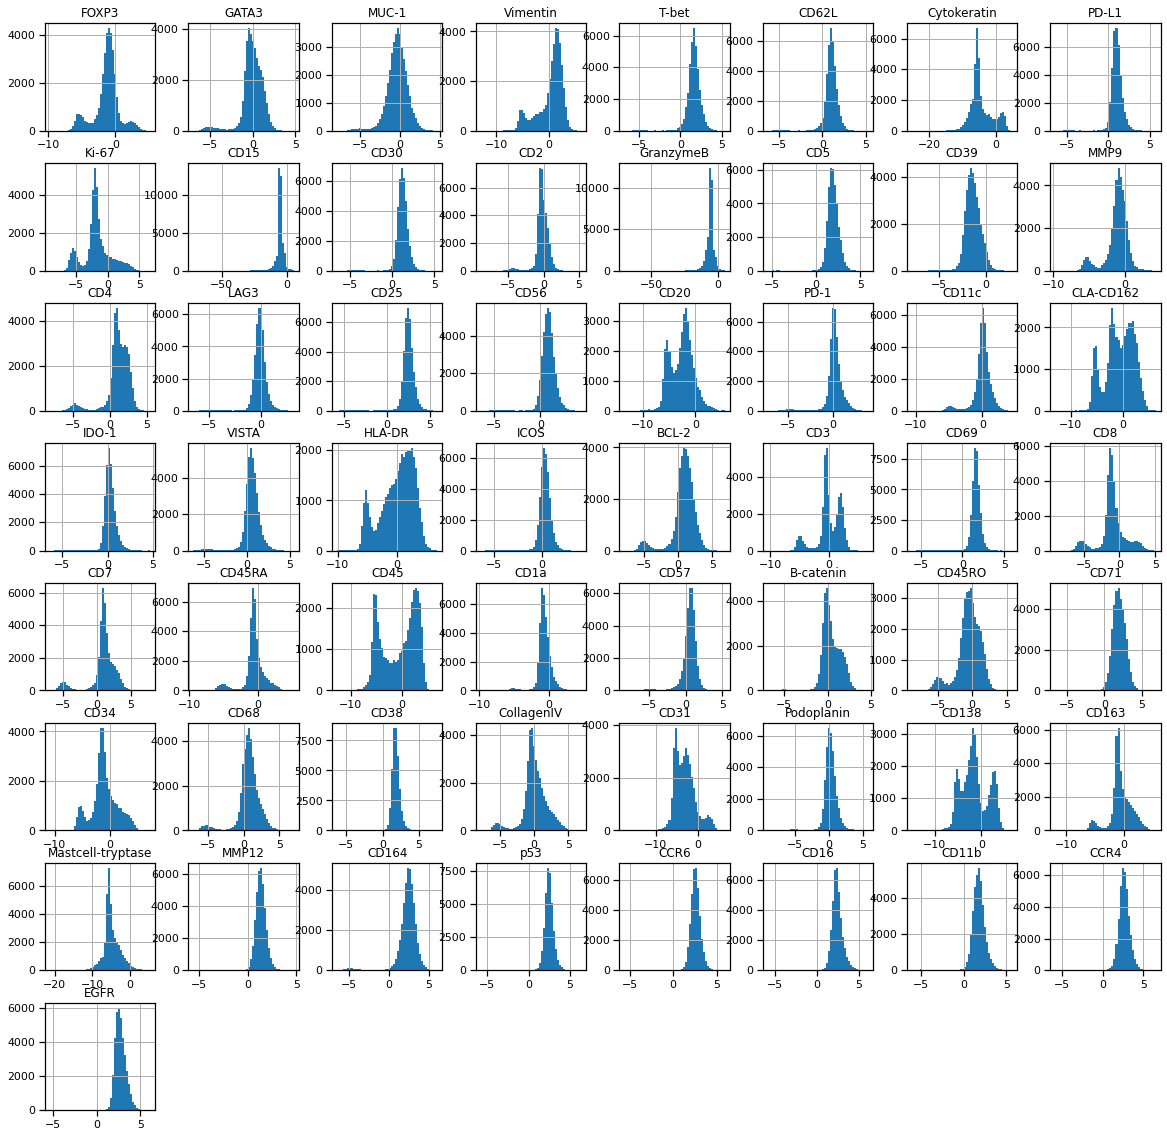

In [100]:
X = obj[aggreg_vars].values
X[X == 0] = X.max() / 100000

X_clr = cs.clr(cs.closure(X))
aggreg_vars_clr = obj[aggreg_vars].copy()
aggreg_vars_clr.loc[:, :] = X_clr
aggreg_vars_clr.hist(bins=50, figsize=(20, 20));

In [101]:
edges_all = pd.read_csv(reconst_dir/ 'all_samples-edges.csv')
pairs = edges_all.values

In [102]:
file_path = nas_dir / f'aggregation_statistics.csv'

if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Computing Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
        stat_funcs=np.mean,
        stat_names='mean',
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [103]:
embedding, reducer = mosna.get_reducer(
    data=var_aggreg, 
    save_dir=nas_dir,
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean', 
    min_dist=0.0,
    )

Loading reducer object and reduced coordinates


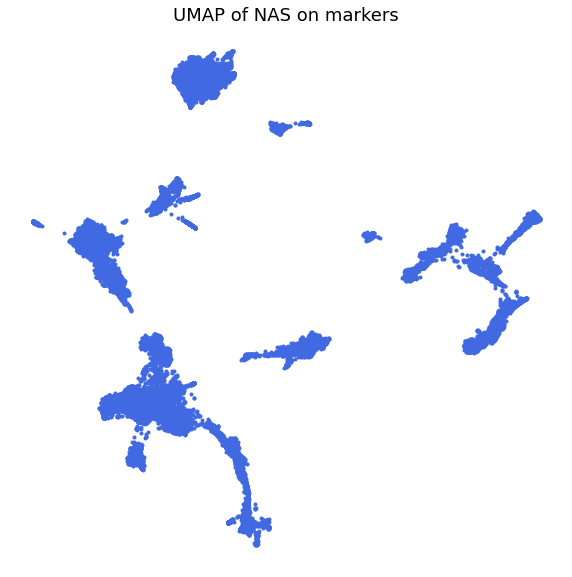

In [104]:
mosna.plot_clusters(embedding)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

#### Leinden clustering

In [107]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 20 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

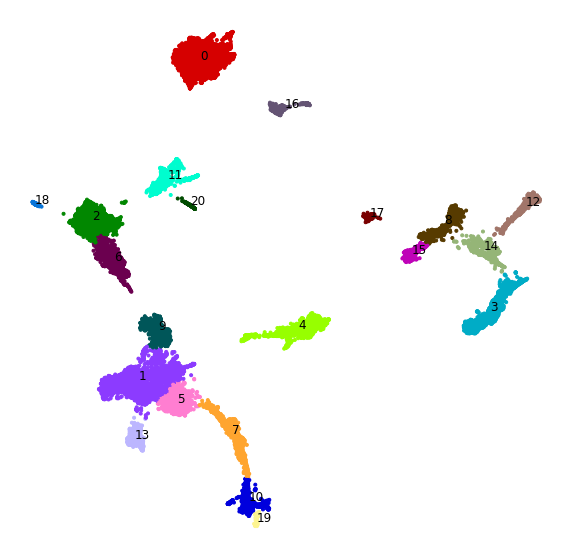

In [108]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap')
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

In [ ]:
# for dim_clust in tqdm([2, 3, 4, 5], leave=False):
for dim_clust in tqdm([2], leave=False):
    for n_neighbors in tqdm([15, 45, 75, 100, 200], leave=False):
        for metric in tqdm(['euclidean', 'cosine'], leave=False):
            for k_cluster in tqdm([15, 50], leave=False):
                cluster_params = {
                    'reducer_type': 'umap', 
                    'n_neighbors': n_neighbors, 
                    'metric': metric,
                    'min_dist': 0.0,
                    'clusterer_type': 'leiden', 
                    'dim_clust': dim_clust, 
                    'k_cluster': 15, 
                    'resolution_parameter': 0.005,
                }

                cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)
                
                embed_viz, _ = mosna.get_reducer(
                    var_aggreg, 
                    nas_dir, 
                    reducer_type='umap', 
                    n_neighbors=n_neighbors, 
                    metric=metric,
                    )
                
                mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

Loading clusterer object and cluster labels
There are 18 clusters
Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

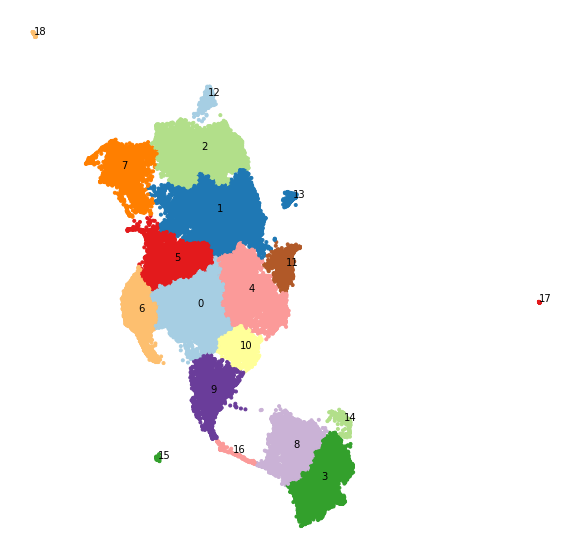

In [31]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 15, 
    'metric': 'euclidean',
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

embed_viz, _ = mosna.get_reducer(
    var_aggreg, 
    nas_dir, 
    reducer_type='umap', 
    n_neighbors=15, 
    metric='euclidean',
    )

mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

In [29]:
# Merge some small adjacent clusters
# merge_dict = {
#     19: 18,
#     21: 17,
#     24: 1,
#     # 23: 1,
#     # 25: 1,
# }
merge_dict = {
    20: 2,
    18: 16,
    19: 16,
    # 23: 1,
    # 25: 1,
}
for old, new in merge_dict.items():
    cluster_labels[cluster_labels == old] = new
    
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)


In [30]:
# rename clusters ordered by size
class_id, class_count = np.unique(cluster_labels, return_counts=True)
decreasing_counts_ids = np.argsort(class_count)[::-1]
new_ids = np.arange(len(class_id))[decreasing_counts_ids]
for old, new in zip(class_id, new_ids):
    cluster_labels[cluster_labels == old] = new

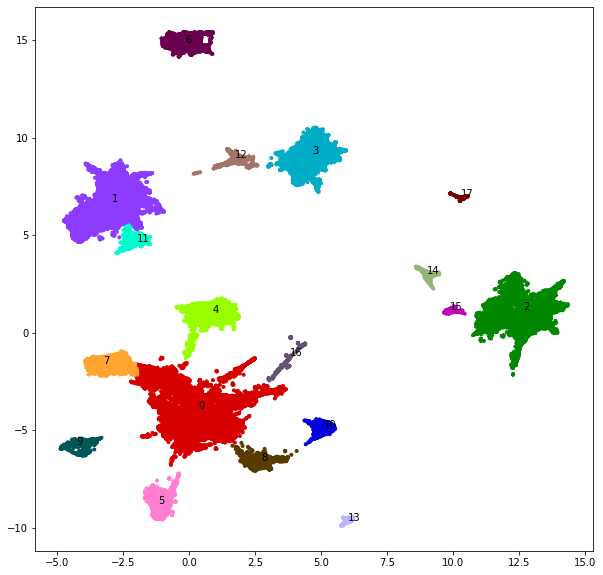

In [31]:
embed_viz = embedding

# choose colormap
if nb_clust < 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

for clust_id in np.unique(cluster_labels):
    clust_targ = cluster_labels == clust_id
    x_mean = embed_viz[clust_targ, 0].mean()
    y_mean = embed_viz[clust_targ, 1].mean()
    plt.text(x_mean, y_mean, str(clust_id))

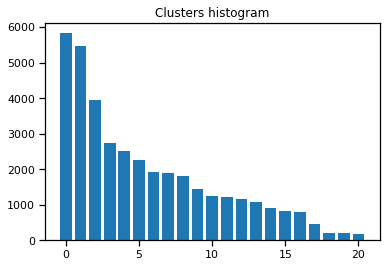

In [109]:
class_id, class_count = np.unique(cluster_labels, return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

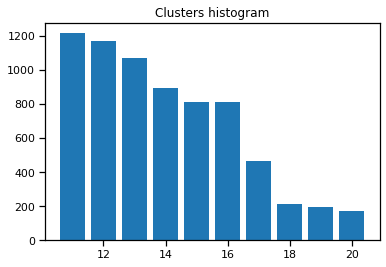

In [110]:
class_id, class_count = np.unique(cluster_labels[cluster_labels > 10], return_counts=True)
plt.bar(class_id, class_count, width=0.8);
plt.title('Clusters histogram');

In [34]:
other_str = '_manual-cleaning'

clusterer_name = f"partition-{'RBConfigurationVertexPartition'}_resolution-{resolution_parameter}{other_str}"
file_path = cluster_dir / clusterer_name

# save cluster labels
np.save(str(file_path) + '.npy', cluster_labels, allow_pickle=False, fix_imports=False)

#### Leiden clustering using scikit knn on UMAP data

In [30]:
import igraph as ig
import leidenalg as la

k_cluster = 15
nas_coords = embedding
nas_pairs = ty.build_knn(nas_coords, k=k_cluster)

G = ty.to_iGraph(nas_coords, nas_pairs, attributes=None)

partition = la.find_partition(G, la.RBConfigurationVertexPartition, resolution_parameter=0.01)
# partition = la.find_partition(G, la.CPMVertexPartition, resolution_parameter=0.00001)
cluster_labels = np.array(partition.membership)
nb_clust = cluster_labels.max()
print(f"Found {nb_clust} clusters")

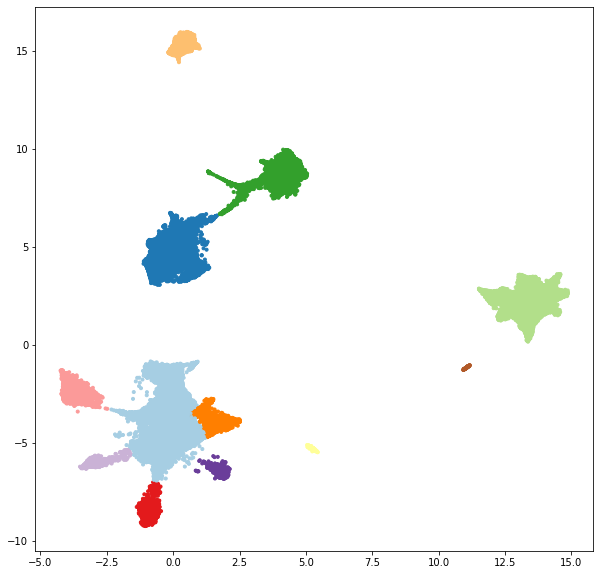

In [65]:
embed_viz = embedding

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = [labels_color_mapper[x] for x in cluster_labels]

plt.figure(figsize=(10,10))
# plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=labels_colors, marker='.');
plt.scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors, marker='.');

That looks great, we'll do the same with n_neighbors=15, see above.

#### On markers, order 2

In [40]:
order = 2
nas_dir = reconstruction_dir / f"nas_on-{var_type}_stats-{stat_names}_order-{order}"    
if not os.path.exists(nas_dir):
    os.makedirs(nas_dir)

file_path = nas_dir / f'aggregation_statistics.csv'
if file_path.is_file():
    print("Loading Neighbors Aggregation Statistics file")
    var_aggreg = pd.read_csv(file_path)
else:
    print("Compouting Neighbors Aggregation Statistics")
    var_aggreg = mosna.aggregate_k_neighbors(
        X=X_clr,
        pairs=pairs,
        order=order,
        var_names=aggreg_vars,
    )
    var_aggreg.to_csv(file_path, index=False)

Loading Neighbors Aggregation Statistics file


In [ ]:
n_neighbors = 70
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl');

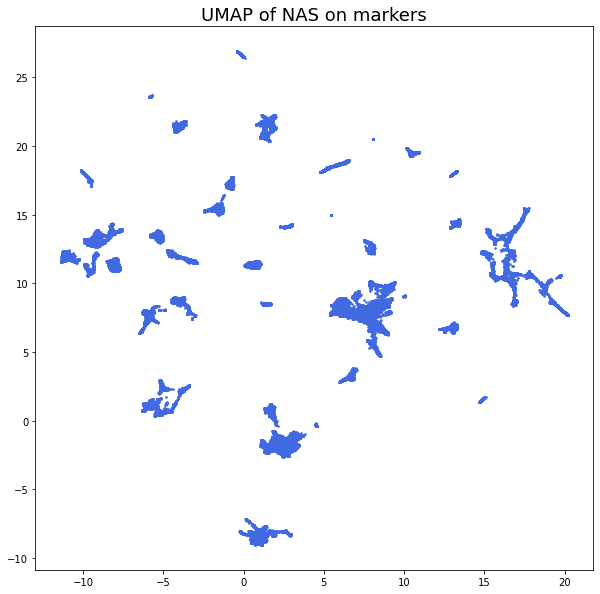

In [44]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

In [45]:
n_neighbors = 100
metric = 'euclidean'
min_dist = 0.0

reducer_name = f"reducer-umap_nneigh-{n_neighbors}_metric-{metric}_min_dist-{min_dist}"
file_path = nas_dir / reducer_name
if os.path.exists(str(file_path) + '.npy'):
    print("Loading reducer object and reduced coordinates")
    embedding = np.load(str(file_path) + '.npy')
    reducer = joblib.load(str(file_path) + '.pkl')
else:
    print("Computing dimensionality reduction")
    reducer = umap.UMAP(
        random_state=0,
        n_neighbors=n_neighbors,
        metric=metric,
        min_dist=min_dist,
        )
    embedding = reducer.fit_transform(var_aggreg)
    # save reduced coordinates
    np.save(str(file_path) + '.npy', embedding, allow_pickle=False, fix_imports=False)
    # save the reducer object
    joblib.dump(reducer, str(file_path) + '.pkl')

Computing dimensionality reduction


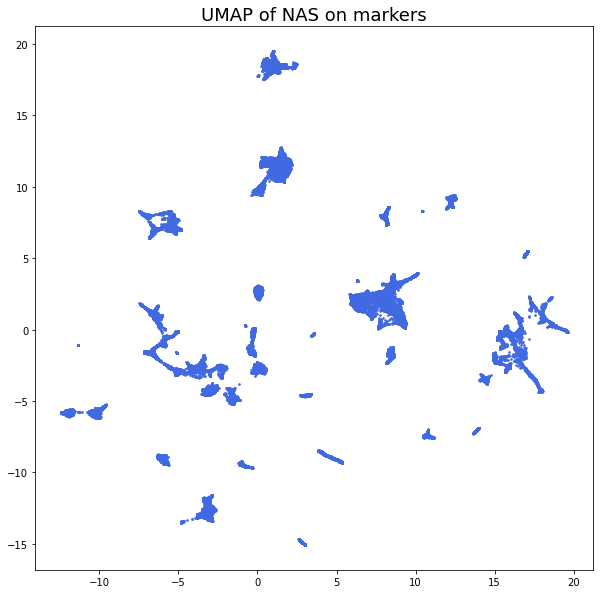

In [46]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='royalblue', marker=marker, s=size_points)
title = f"UMAP of NAS on {var_type}"
plt.title(title, fontsize=18);

## Survival analysis

We use labels from the Leiden clustering.

In [111]:
cell_types = nodes_all['CellCluster']
niches = cluster_labels

Text(0.5, 1.0, 'niche cell-types composition, normalized by cell-type')

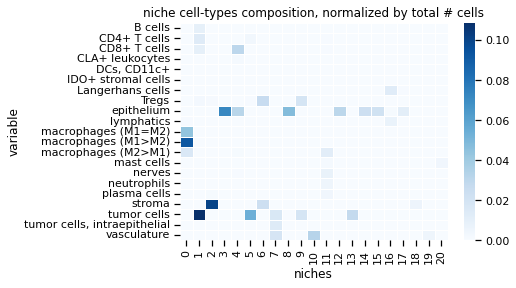

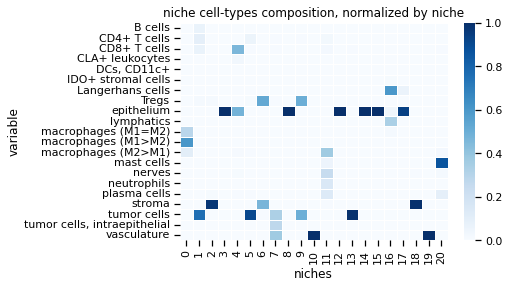

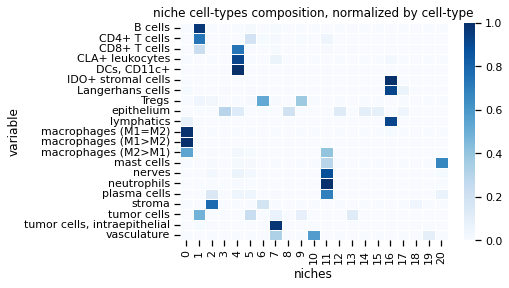

In [112]:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
plt.title("niche cell-types composition, normalized by total # cells")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
plt.title("niche cell-types composition, normalized by cell-type")

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

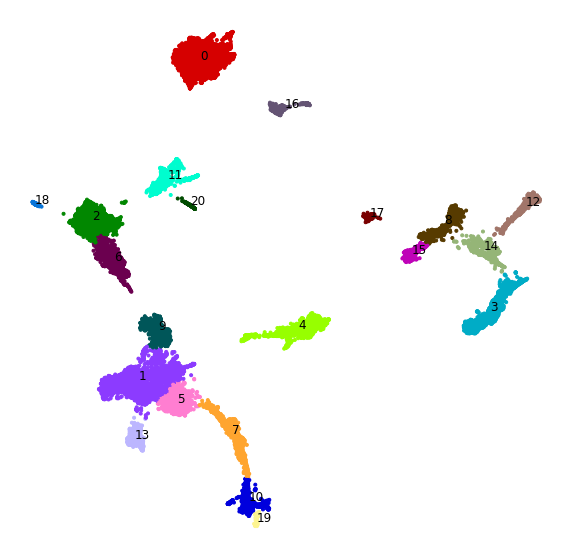

In [113]:
mosna.plot_clusters(embed_viz, cluster_labels, cluster_params=cluster_params)

In [123]:
# proportion of cells in niches per sample
normalize = 'obs'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.235972  0.253651  0.017679  0.000000  0.079170  0.002306   
reg002    0.299053  0.070568  0.156196  0.000000  0.016351  0.006885   
reg005    0.125000  0.000000  0.410714  0.000000  0.017857  0.000000   
reg006    0.295191  0.175788  0.257048  0.000000  0.008292  0.011609   
reg009    0.150386  0.029991  0.062125  0.414739  0.042845  0.139674   
...            ...       ...       ...       ...       ...       ...   
reg046    0.193069  0.240099  0.023515  0.000000  0.037129  0.025990   
reg051    0.101664  0.017560  0.130314  0.000924  0.005545  0.182070   
reg052    0.074985  0.008787  0.056239  0.031634  0.003515  0.138840   
reg057    0.163808  0.168096  0.042024  0.000858  0.064322  0.022298   
reg058    0.149946  0.036138  0.037756  0.000539  0.017799  0.009709   

niches          6         7         8         9   ...        11        12  \
variable                                          ...                       
reg001    0.074558  0.064566  0.000000  0.019985  ...  0.064566  0.000000   
reg002    0.103270  0.047762  0.000000  0.233649  ...  0.039587  0.000000   
reg005    0.000000  0.383929  0.000000  0.035714  ...  0.000000  0.000000   
reg006    0.023217  0.086235  0.000000  0.094527  ...  0.009950  0.000000   
reg009    0.020994  0.075407  0.001714  0.001714  ...  0.006427  0.000428   
...            ...       ...       ...       ...  ...       ...       ...   
reg046    0.112624  0.047030  0.000000  0.043317  ...  0.018564  0.153465   
reg051    0.011091  0.007394  0.384473  0.000924  ...  0.027726  0.000000   
reg052    0.016989  0.005272  0.538957  0.004101  ...  0.024605  0.000586   
reg057    0.057461  0.199828  0.000000  0.176672  ...  0.012864  0.000000   
reg058    0.025890  0.213592  0.000000  0.183927  ...  0.009709  0.000000   

niches          13        14        15        16        17        18   19  \
variable                                                                    
reg001    0.000000  0.000000  0.000000  0.028440  0.000000  0.152959  0.0   
reg002    0.000861  0.000000  0.000000  0.012048  0.000000  0.004733  0.0   
reg005    0.000000  0.000000  0.000000  0.000000  0.000000  0.008929  0.0   
reg006    0.000000  0.000000  0.000000  0.026534  0.000000  0.006633  0.0   
reg009    0.000000  0.000000  0.000000  0.035561  0.000857  0.000000  0.0   
...            ...       ...       ...       ...       ...       ...  ...   
reg046    0.001238  0.000000  0.000000  0.038366  0.000000  0.000000  0.0   
reg051    0.001848  0.005545  0.003697  0.020333  0.002773  0.000000  0.0   
reg052    0.000000  0.059168  0.000586  0.019918  0.000000  0.000000  0.0   
reg057    0.000000  0.000000  0.000000  0.028302  0.003431  0.000000  0.0   
reg058    0.000000  0.000000  0.000000  0.032902  0.231392  0.000000  0.0   

niches          20  
variable            
reg001    0.003843  
reg002    0.008176  
reg005    0.008929  
reg006    0.003317  
reg009    0.004713  
...            ...  
reg046    0.003713  
reg051    0.008318  
reg052    0.001757  
reg057    0.000000  
reg058    0.000000  

[29 rows x 21 columns]

In [124]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [125]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.267513  0.162110  0.086937  0.000000  0.047760  0.004595   
2        1       0.210095  0.087894  0.333881  0.000000  0.013075  0.005804   
3        2       0.138391  0.032001  0.078778  0.406354  0.041473  0.142934   
4        2       0.101356  0.062346  0.115425  0.296862  0.016656  0.004926   
5        1       0.023462  0.002884  0.034070  0.003275  0.885915  0.001792   
6        2       0.219416  0.277856  0.143697  0.001894  0.146372  0.001679   
7        2       0.064324  0.009309  0.471493  0.000000  0.013200  0.003891   
8        2       0.082162  0.406335  0.058871  0.004349  0.017202  0.011226   
9        1       0.110924  0.027801  0.200127  0.000000  0.051450  0.257295   
10       1       0.244886  0.033610  0.170444  0.000759  0.000000  0.063870   
11       1       0.139772  0.016507  0.270177  0.003167  0.002656  0.101974   
12       2       0.162888  0.223498  0.024035  0.000000  0.037373  0.019787   
13       1       0.088324  0.013174  0.093277  0.016279  0.004530  0.160455   
14       2       0.156877  0.102117  0.039890  0.000699  0.041061  0.016004   

                       6         7         8         9   ...        11  \
Patients Groups                                          ...             
1        1       0.088914  0.056164  0.000000  0.126817  ...  0.052076   
2        1       0.011609  0.235082  0.000000  0.065121  ...  0.004975   
3        2       0.022172  0.064353  0.001365  0.001111  ...  0.007782   
4        2       0.002991  0.002031  0.000677  0.000000  ...  0.004912   
5        1       0.004872  0.019878  0.001092  0.003780  ...  0.005067   
6        2       0.071707  0.005601  0.000000  0.001277  ...  0.016995   
7        2       0.000000  0.000000  0.000000  0.000000  ...  0.359692   
8        2       0.143196  0.003556  0.000349  0.004696  ...  0.126234   
9        1       0.002757  0.086165  0.011847  0.013961  ...  0.009874   
10       1       0.036097  0.115533  0.003968  0.000380  ...  0.005572   
11       1       0.034154  0.008145  0.185009  0.003167  ...  0.007457   
12       2       0.067806  0.046765  0.000522  0.054574  ...  0.013984   
13       1       0.014040  0.006333  0.461715  0.002512  ...  0.026166   
14       2       0.041676  0.206710  0.000000  0.180300  ...  0.011287   

                       12        13        14        15        16        17  \
Patients Groups                                                               
1        1       0.000000  0.000430  0.000000  0.000000  0.020244  0.000000   
2        1       0.000000  0.000000  0.000000  0.000000  0.013267  0.000000   
3        2       0.000214  0.000254  0.000000  0.000254  0.032501  0.001190   
4        2       0.003937  0.317321  0.001181  0.000000  0.006314  0.000000   
5        1       0.000000  0.000000  0.004171  0.000896  0.005963  0.000000   
6        2       0.000000  0.018526  0.000430  0.000000  0.038164  0.002673   
7        2       0.000000  0.000000  0.000000  0.000000  0.009728  0.000000   
8        2       0.060790  0.000000  0.000174  0.000175  0.013560  0.000175   
9        1       0.000000  0.000244  0.010526  0.194428  0.007046  0.000487   
10       1       0.000000  0.003968  0.286659  0.000000  0.017038  0.000380   
11       1       0.000000  0.000000  0.013122  0.004977  0.016448  0.002656   
12       2       0.266127  0.000880  0.000000  0.000000  0.033551  0.001045   
13       1       0.000293  0.000924  0.032357  0.002141  0.020125  0.001386   
14       2       0.000000  0.000000  0.000000  0.000000  0.030602  0.117411   

                       18        19        20  
Patients Groups                                
1        1       0.078846  0.000000  0.006009  
2        1       0.007781  0.000000  0.006123  
3        2       0.000000  0.000000  0.007940  
4        2       0.000000  0.000000  0.002204  
5        1       0.0

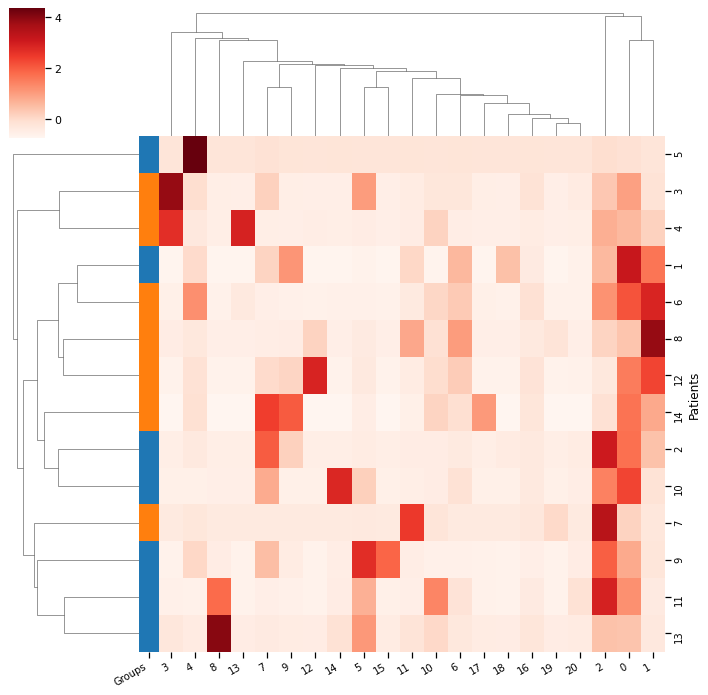

In [126]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

# figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-obs.png"
# plt.savefig(cluster_dir / figname)

In [127]:
# proportion of cells in niches per sample, normalized per niche total count
normalize = 'niche'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.052677  0.060362  0.005830  0.000000  0.041134  0.001336   
reg002    0.119252  0.029998  0.092015  0.000000  0.015176  0.007124   
reg005    0.002402  0.000000  0.011660  0.000000  0.000799  0.000000   
reg006    0.030542  0.019389  0.039290  0.000000  0.001997  0.003117   
reg009    0.060226  0.012804  0.036755  0.353285  0.039936  0.145147   
...            ...       ...       ...       ...       ...       ...   
reg046    0.026767  0.035486  0.004816  0.000000  0.011981  0.009350   
reg051    0.018874  0.003475  0.035741  0.000365  0.002396  0.087711   
reg052    0.021963  0.002744  0.024335  0.019708  0.002396  0.105521   
reg057    0.032773  0.035851  0.012421  0.000365  0.029952  0.011576   
reg058    0.047701  0.012255  0.017744  0.000365  0.013179  0.008014   

niches          6         7         8         9   ...        11        12  \
variable                                          ...                       
reg001    0.050679  0.044187  0.000000  0.017956  ...  0.069079  0.000000   
reg002    0.125392  0.058390  0.000000  0.375000  ...  0.075658  0.000000   
reg005    0.000000  0.022620  0.000000  0.002762  ...  0.000000  0.000000   
reg006    0.007315  0.027354  0.000000  0.039365  ...  0.004934  0.000000   
reg009    0.025601  0.092583  0.002210  0.002762  ...  0.012336  0.000855   
...            ...       ...       ...       ...  ...       ...       ...   
reg046    0.047544  0.019989  0.000000  0.024171  ...  0.012336  0.105983   
reg051    0.006270  0.004208  0.229834  0.000691  ...  0.024671  0.000000   
reg052    0.015152  0.004734  0.508287  0.004834  ...  0.034539  0.000855   
reg057    0.035005  0.122567  0.000000  0.142265  ...  0.012336  0.000000   
reg058    0.025078  0.208311  0.000000  0.235497  ...  0.014803  0.000000   

niches          13        14        15        16        17        18   19  \
variable                                                                    
reg001    0.000000  0.000000  0.000000  0.045679  0.000000  0.925581  0.0   
reg002    0.001873  0.000000  0.000000  0.034568  0.000000  0.051163  0.0   
reg005    0.000000  0.000000  0.000000  0.000000  0.000000  0.004651  0.0   
reg006    0.000000  0.000000  0.000000  0.019753  0.000000  0.018605  0.0   
reg009    0.000000  0.000000  0.000000  0.102469  0.004292  0.000000  0.0   
...            ...       ...       ...       ...       ...       ...  ...   
reg046    0.000936  0.000000  0.000000  0.038272  0.000000  0.000000  0.0   
reg051    0.001873  0.006704  0.004908  0.027160  0.006438  0.000000  0.0   
reg052    0.000000  0.112849  0.001227  0.041975  0.000000  0.000000  0.0   
reg057    0.000000  0.000000  0.000000  0.040741  0.008584  0.000000  0.0   
reg058    0.000000  0.000000  0.000000  0.075309  0.920601  0.000000  0.0   

niches          20  
variable            
reg001    0.028902  
reg002    0.109827  
reg005    0.005780  
reg006    0.011561  
reg009    0.063584  
...            ...  
reg046    0.017341  
reg051    0.052023  
reg052    0.017341  
reg057    0.000000  
reg058    0.000000  

[29 rows x 21 columns]

In [128]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [129]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.085964  0.045180  0.048923  0.000000  0.028155  0.004230   
2        1       0.016472  0.009695  0.025475  0.000000  0.001398  0.001558   
3        2       0.051476  0.012530  0.042205  0.319708  0.035743  0.136687   
4        2       0.026081  0.019023  0.045120  0.161496  0.010184  0.003785   
5        1       0.002059  0.000274  0.004183  0.000547  0.180112  0.000445   
6        2       0.090683  0.122188  0.087326  0.001642  0.140775  0.001781   
7        2       0.002231  0.000366  0.022560  0.000000  0.001198  0.000445   
8        2       0.025967  0.128102  0.022391  0.003041  0.012247  0.006827   
9        1       0.017759  0.007042  0.044994  0.000000  0.038938  0.149377   
10       1       0.053535  0.007774  0.054626  0.000365  0.000000  0.036064   
11       1       0.018960  0.002652  0.037516  0.001277  0.000799  0.038513   
12       2       0.035175  0.053960  0.008365  0.000000  0.020367  0.010463   
13       1       0.020419  0.003110  0.030038  0.010036  0.002396  0.096616   
14       2       0.040237  0.024053  0.015082  0.000365  0.021565  0.009795   

                       6         7         8         9   ...        11  \
Patients Groups                                          ...             
1        1       0.088036  0.051289  0.000000  0.196478  ...  0.072368   
2        1       0.003657  0.024987  0.000000  0.021064  ...  0.002467   
3        2       0.024817  0.073908  0.001657  0.001727  ...  0.013569   
4        2       0.002351  0.001578  0.000552  0.000000  ...  0.006168   
5        1       0.001306  0.005260  0.000276  0.001381  ...  0.002056   
6        2       0.089864  0.007102  0.000000  0.002072  ...  0.033306   
7        2       0.000000  0.000000  0.000000  0.000000  ...  0.060855   
8        2       0.113201  0.002806  0.000368  0.005525  ...  0.157895   
9        1       0.002351  0.046028  0.012155  0.018992  ...  0.006168   
10       1       0.024033  0.077591  0.002762  0.000345  ...  0.005757   
11       1       0.017764  0.004734  0.112431  0.002417  ...  0.003701   
12       2       0.035266  0.033403  0.000552  0.055594  ...  0.013569   
13       1       0.010711  0.004471  0.369061  0.002762  ...  0.029605   
14       2       0.030042  0.165439  0.000000  0.188881  ...  0.013569   

                       12        13        14        15        16        17  \
Patients Groups                                                               
1        1       0.000000  0.000936  0.000000  0.000000  0.040123  0.000000   
2        1       0.000000  0.000000  0.000000  0.000000  0.009877  0.000000   
3        2       0.000427  0.000468  0.000000  0.000613  0.087037  0.005365   
4        2       0.004274  0.448502  0.001676  0.000000  0.011111  0.000000   
5        1       0.000000  0.000000  0.002235  0.000613  0.003704  0.000000   
6        2       0.000000  0.043071  0.001117  0.000000  0.112963  0.013948   
7        2       0.000000  0.000000  0.000000  0.000000  0.003086  0.000000   
8        2       0.088034  0.000000  0.000372  0.000409  0.022634  0.000715   
9        1       0.000000  0.000468  0.011173  0.488344  0.009259  0.002146   
10       1       0.000000  0.004682  0.407263  0.000000  0.026543  0.001073   
11       1       0.000000  0.000000  0.016201  0.006748  0.016667  0.004292   
12       2       0.362821  0.000936  0.000000  0.000000  0.053086  0.004292   
13       1       0.000427  0.000936  0.059777  0.003067  0.034568  0.003219   
14       2       0.000000  0.000000  0.000000  0.000000  0.058025  0.464592   

                       18        19        20  
Patients Groups                                
1        1       0.488372  0.000000  0.069364  
2        1       0.011628  0.000000  0.008671  
3        2       0.000000  0.000000  0.095376  
4        2       0.000000  0.000000  0.020231  
5        1       0.0

In [130]:
counts_clinic.sum(axis=0)

0     0.487017
1     0.435949
2     0.488804
3     0.498479
4     0.493876
        ...   
16    0.488683
17    0.499642
18    0.500000
19    0.354922
20    0.497110
Length: 21, dtype: float64

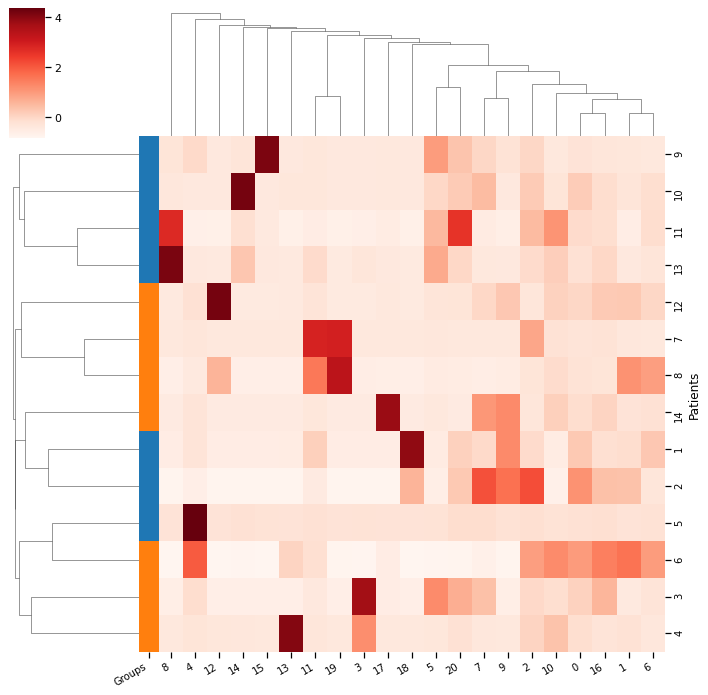

In [131]:
g, d = mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

# figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-niche.png"
# plt.savefig(cluster_dir / figname)

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

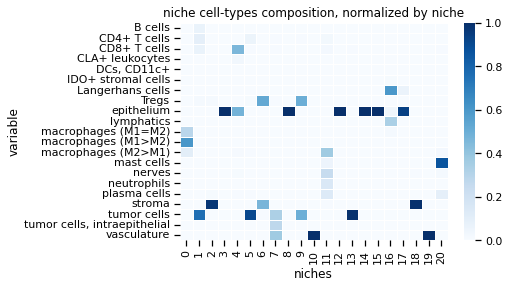

In [132]:
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
# plt.title("niche cell-types composition, normalized by total # cells")
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")
# mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
# plt.title("niche cell-types composition, normalized by cell-type")

~~That look just great, but even if the idea that we should also somehow take into account proportions per niche for normalization sounds correct, it doesn't seem right to ignore proportions per patient. For example if we normalize by the total number of cells we obtain again a very different result:~~

In [133]:
# proportion of cells in niches per sample, normalized per total count
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='total')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    0.008065  0.008669  0.000604  0.000000  0.002706  0.000079   
reg002    0.018258  0.004308  0.009536  0.000000  0.000998  0.000420   
reg005    0.000368  0.000000  0.001208  0.000000  0.000053  0.000000   
reg006    0.004676  0.002785  0.004072  0.000000  0.000131  0.000184   
reg009    0.009221  0.001839  0.003809  0.025430  0.002627  0.008564   
...            ...       ...       ...       ...       ...       ...   
reg046    0.004098  0.005097  0.000499  0.000000  0.000788  0.000552   
reg051    0.002890  0.000499  0.003704  0.000026  0.000158  0.005175   
reg052    0.003363  0.000394  0.002522  0.001419  0.000158  0.006226   
reg057    0.005018  0.005149  0.001287  0.000026  0.001970  0.000683   
reg058    0.007303  0.001760  0.001839  0.000026  0.000867  0.000473   

niches          6         7         8         9   ...        11        12  \
variable                                          ...                       
reg001    0.002548  0.002207  0.000000  0.000683  ...  0.002207  0.000000   
reg002    0.006305  0.002916  0.000000  0.014265  ...  0.002417  0.000000   
reg005    0.000000  0.001130  0.000000  0.000105  ...  0.000000  0.000000   
reg006    0.000368  0.001366  0.000000  0.001497  ...  0.000158  0.000000   
reg009    0.001287  0.004624  0.000105  0.000105  ...  0.000394  0.000026   
...            ...       ...       ...       ...  ...       ...       ...   
reg046    0.002391  0.000998  0.000000  0.000919  ...  0.000394  0.003258   
reg051    0.000315  0.000210  0.010929  0.000026  ...  0.000788  0.000000   
reg052    0.000762  0.000236  0.024169  0.000184  ...  0.001103  0.000026   
reg057    0.001760  0.006121  0.000000  0.005412  ...  0.000394  0.000000   
reg058    0.001261  0.010403  0.000000  0.008958  ...  0.000473  0.000000   

niches          13        14        15        16        17        18   19  \
variable                                                                    
reg001    0.000000  0.000000  0.000000  0.000972  0.000000  0.005228  0.0   
reg002    0.000053  0.000000  0.000000  0.000736  0.000000  0.000289  0.0   
reg005    0.000000  0.000000  0.000000  0.000000  0.000000  0.000026  0.0   
reg006    0.000000  0.000000  0.000000  0.000420  0.000000  0.000105  0.0   
reg009    0.000000  0.000000  0.000000  0.002180  0.000053  0.000000  0.0   
...            ...       ...       ...       ...       ...       ...  ...   
reg046    0.000026  0.000000  0.000000  0.000814  0.000000  0.000000  0.0   
reg051    0.000053  0.000158  0.000105  0.000578  0.000079  0.000000  0.0   
reg052    0.000000  0.002653  0.000026  0.000893  0.000000  0.000000  0.0   
reg057    0.000000  0.000000  0.000000  0.000867  0.000105  0.000000  0.0   
reg058    0.000000  0.000000  0.000000  0.001603  0.011270  0.000000  0.0   

niches          20  
variable            
reg001    0.000131  
reg002    0.000499  
reg005    0.000026  
reg006    0.000053  
reg009    0.000289  
...            ...  
reg046    0.000079  
reg051    0.000236  
reg052    0.000079  
reg057    0.000000  
reg058    0.000000  

[29 rows x 21 columns]

In [134]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [135]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       0.013162  0.006489  0.005070  0.000000  0.001852  0.000250   
2        1       0.002522  0.001392  0.002640  0.000000  0.000092  0.000092   
3        2       0.007881  0.001800  0.004374  0.023013  0.002351  0.008065   
4        2       0.003993  0.002732  0.004676  0.011625  0.000670  0.000223   
5        1       0.000315  0.000039  0.000433  0.000039  0.011848  0.000026   
6        2       0.013884  0.017549  0.009050  0.000118  0.009260  0.000105   
7        2       0.000342  0.000053  0.002338  0.000000  0.000079  0.000026   
8        2       0.003976  0.018398  0.002321  0.000219  0.000806  0.000403   
9        1       0.002719  0.001011  0.004663  0.000000  0.002561  0.008814   
10       1       0.008197  0.001117  0.005661  0.000026  0.000000  0.002128   
11       1       0.002903  0.000381  0.003888  0.000092  0.000053  0.002272   
12       2       0.005386  0.007750  0.000867  0.000000  0.001340  0.000617   
13       1       0.003126  0.000447  0.003113  0.000722  0.000158  0.005701   
14       2       0.006161  0.003455  0.001563  0.000026  0.001419  0.000578   

                       6         7         8         9   ...        11  \
Patients Groups                                          ...             
1        1       0.004427  0.002561  0.000000  0.007474  ...  0.002312   
2        1       0.000184  0.001248  0.000000  0.000801  ...  0.000079   
3        2       0.001248  0.003691  0.000079  0.000066  ...  0.000433   
4        2       0.000118  0.000079  0.000026  0.000000  ...  0.000197   
5        1       0.000066  0.000263  0.000013  0.000053  ...  0.000066   
6        2       0.004519  0.000355  0.000000  0.000079  ...  0.001064   
7        2       0.000000  0.000000  0.000000  0.000000  ...  0.001944   
8        2       0.005692  0.000140  0.000018  0.000210  ...  0.005044   
9        1       0.000118  0.002299  0.000578  0.000722  ...  0.000197   
10       1       0.001208  0.003875  0.000131  0.000013  ...  0.000184   
11       1       0.000893  0.000236  0.005346  0.000092  ...  0.000118   
12       2       0.001773  0.001668  0.000026  0.002115  ...  0.000433   
13       1       0.000539  0.000223  0.017549  0.000105  ...  0.000946   
14       2       0.001511  0.008262  0.000000  0.007185  ...  0.000433   

                       12        13        14        15        16        17  \
Patients Groups                                                               
1        1       0.000000  0.000026  0.000000  0.000000  0.000854  0.000000   
2        1       0.000000  0.000000  0.000000  0.000000  0.000210  0.000000   
3        2       0.000013  0.000013  0.000000  0.000013  0.001852  0.000066   
4        2       0.000131  0.012584  0.000039  0.000000  0.000236  0.000000   
5        1       0.000000  0.000000  0.000053  0.000013  0.000079  0.000000   
6        2       0.000000  0.001208  0.000026  0.000000  0.002404  0.000171   
7        2       0.000000  0.000000  0.000000  0.000000  0.000066  0.000000   
8        2       0.002706  0.000000  0.000009  0.000009  0.000482  0.000009   
9        1       0.000000  0.000013  0.000263  0.010456  0.000197  0.000026   
10       1       0.000000  0.000131  0.009576  0.000000  0.000565  0.000013   
11       1       0.000000  0.000000  0.000381  0.000144  0.000355  0.000053   
12       2       0.011152  0.000026  0.000000  0.000000  0.001130  0.000053   
13       1       0.000013  0.000026  0.001405  0.000066  0.000736  0.000039   
14       2       0.000000  0.000000  0.000000  0.000000  0.001235  0.005688   

                       18        19        20  
Patients Groups                                
1        1       0.002758  0.000000  0.000315  
2        1       0.000066  0.000000  0.000039  
3        2       0.000000  0.000000  0.000433  
4        2       0.000000  0.000000  0.000092  
5        1       0.0

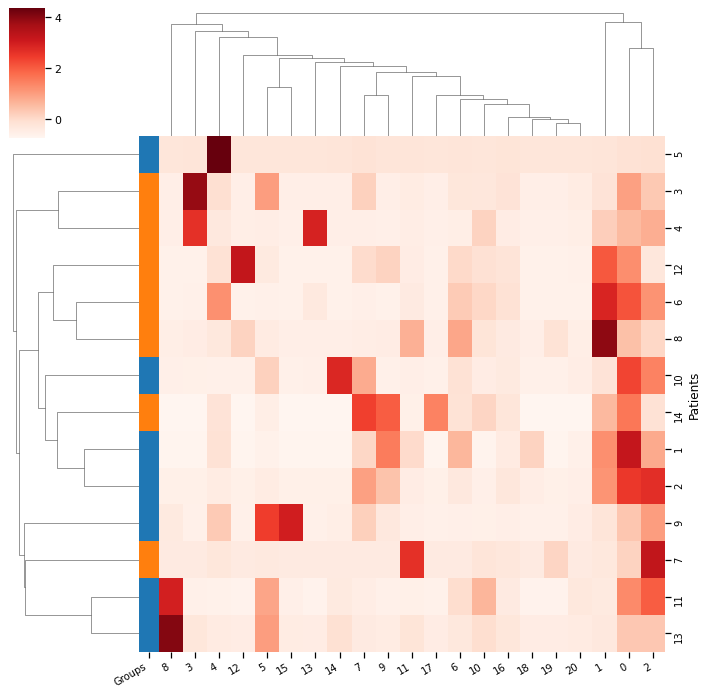

In [137]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

# figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-total.png"
# plt.savefig(cluster_dir / figname)

A more statistically sound way to take jointly into account proportions per variable and per observation is the Central Log Ratio, that we already applied to protein composition:

In [138]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize='clr')
counts

niches          0         1         2         3         4         5   \
variable                                                               
reg001    5.140962  5.213207  2.549608 -5.135621  4.048843  0.512726   
reg002    5.440573  3.996528  4.791064 -5.653074  2.534248  1.669250   
reg005    4.869449 -2.319344  6.059033 -2.319344  2.923539 -2.319344   
reg006    5.214010  4.695665  5.075651 -4.517509  1.641664  1.978136   
reg009    4.192941  2.580650  3.308888  5.207386  2.937324  4.119052   
...            ...       ...       ...       ...       ...       ...   
reg046    4.310024  4.528026  2.204607 -5.289568  2.661365  2.304690   
reg051    3.042022  1.285981  3.290302 -1.658458  0.133301  3.624745   
reg052    3.153701  1.009721  2.866019  2.290655  0.093430  3.769731   
reg057    4.660708  4.686550  3.300255 -0.591565  3.725923  2.666532   
reg058    4.800940  3.378012  3.421814 -0.826681  2.669827  2.063691   

niches          6         7         8         9   ...        11        12  \
variable                                          ...                       
reg001    3.988825  3.844931 -5.135621  2.672211  ...  3.844931 -5.135621   
reg002    4.377300  3.606192 -5.653074  5.193771  ...  3.418450 -5.653074   
reg005   -2.319344  5.991592 -2.319344  3.616686  ... -2.319344 -2.319344   
reg006    2.671283  3.983470 -4.517509  4.075277  ...  1.823985 -4.517509   
reg009    2.223975  3.502638 -0.281551 -0.281551  ...  1.040205 -1.667846   
...            ...       ...       ...       ...  ...       ...       ...   
reg046    3.771027  2.897754 -5.289568  2.815516  ...  1.968218  4.080450   
reg051    0.826448  0.420983  4.372227 -1.658458  ...  1.742739 -6.208194   
reg052    1.668967  0.498895  5.126045  0.247581  ...  2.039341 -1.698329   
reg057    3.613128  4.859474 -5.141300  4.736311  ...  2.116485 -5.141300   
reg058    3.044520  5.154733 -5.376416  5.005202  ...  2.063691 -5.376416   

niches          13        14        15        16        17        18  \
variable                                                               
reg001   -5.135621 -5.135621 -5.135621  3.025032 -5.135621  4.707419   
reg002   -0.410191 -5.653074 -5.653074  2.228866 -5.653074  1.294557   
reg005   -2.319344 -2.319344 -2.319344 -2.319344 -2.319344  2.230391   
reg006   -4.517509 -4.517509 -4.517509  2.804815 -4.517509  1.418520   
reg009   -6.217581 -6.217581 -6.217581  2.750995 -0.974699 -6.217581   
...            ...       ...       ...       ...       ...       ...   
reg046   -0.739832 -5.289568 -5.289568  2.694155 -5.289568 -5.289568   
reg051   -0.965311  0.133301 -0.272164  1.432584 -0.559846 -6.208194   
reg052   -6.248065  2.916791 -1.698329  1.828031 -6.248065 -6.248065   
reg057   -5.141300 -5.141300 -5.141300  2.904943  0.794729 -5.141300   
reg058   -5.376416 -5.376416 -5.376416  3.284193  5.234776 -5.376416   

niches          19        20  
variable                      
reg001   -5.135621  1.023552  
reg002   -5.653074  1.841101  
reg005   -2.319344  2.230391  
reg006   -4.517509  0.725373  
reg009   -6.217581  0.730050  
...            ...       ...  
reg046   -5.289568  0.358780  
reg051   -6.208194  0.538766  
reg052   -6.248065 -0.599717  
reg057   -5.141300 -5.141300  
reg058   -5.376416 -5.376416  

[29 rows x 21 columns]

In [139]:
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

In [140]:
counts_clinic

0         1         2         3         4         5   \
Patients Groups                                                               
1        1       5.290768  4.604867  3.670336 -5.394348  3.291545  1.090988   
2        1       5.041729  1.188161  5.567342 -3.418427  2.282601 -0.170604   
3        2       3.954408  2.491882  3.371876  5.035109  2.752597  3.990217   
4        2       4.155117  3.440565  4.282720  5.226401  2.350356  0.521790   
5        1       3.199149  1.074901  3.447368 -0.997234  6.832575 -1.199966   
6        2       5.031370  5.269251  4.606358  0.210742  4.626849  0.119581   
7        2       4.528234  2.562321  6.498548 -2.536721  2.817734  0.084721   
8        2       3.469319  5.299883  3.336368 -3.095524  1.987635  1.344135   
9        1       3.542809  2.345541  4.073938 -5.645926  2.494986  4.572083   
10       1       4.908691  2.914842  4.537954 -2.757319 -5.378761  3.565119   
11       1       4.009594  1.807577  4.498332 -1.796921  0.054298  3.659461   
12       2       4.142336  4.473378  2.246035 -5.700994  2.687673  2.000051   
13       1       3.097862  1.147851  3.078160  0.316098  0.113366  3.697238   
14       2       4.730824  4.032281  3.361035 -0.709123  3.197875  2.365111   

                       6         7         8         9   ...        11  \
Patients Groups                                          ...             
1        1       4.183063  3.725561 -5.394348  3.932991  ...  3.631690   
2        1       0.175970  4.987531 -3.418427  3.845982  ... -0.247679   
3        2       2.125519  3.177511 -0.694991 -1.041564  ...  1.064499   
4        2       0.633362  0.234108 -0.864504 -5.414239  ...  1.129988   
5        1       1.624208  3.030913 -1.546540  1.277634  ...  1.624208   
6        2       3.912442  1.362034 -5.784180 -0.429725  ...  2.438561   
7        2      -2.536721 -2.536721 -2.536721 -2.536721  ...  6.245649   
8        2       4.212328  0.386124 -2.651904  0.858479  ...  3.947894   
9        1      -0.056470  3.368196  1.119218  0.898302  ...  0.795904   
10       1       2.993674  4.151948  0.760002 -3.103893  ...  1.074306   
11       1       2.277581 -1.324690  2.508169 -1.796921  ...  1.002858   
12       2       2.996266  2.911853 -3.079553  3.044556  ...  1.647952   
13       1       1.247708  0.459939  4.749136 -0.705439  ...  1.891040   
14       2       3.328824  5.007103 -5.258858  4.870756  ...  2.090088   

                       12        13        14        15        16        17  \
Patients Groups                                                               
1        1      -5.394348 -2.772906 -5.394348 -5.394348  2.626949 -5.394348   
2        1      -3.418427 -3.418427 -3.418427 -3.418427  0.242735 -3.418427   
3        2      -4.009579 -4.009579 -6.284447 -4.009579  2.504930 -0.838832   
4        2      -1.988079  5.298472 -2.590065 -5.414239  1.307399 -5.414239   
5        1      -3.821408 -3.821408  1.277634 -1.546540  1.826940 -3.821408   
6        2      -5.784180 -1.248417 -3.162738 -5.784180  3.280684  0.557315   
7        2      -2.536721 -2.536721 -2.536721 -2.536721  0.542866 -2.536721   
8        2       3.419320 -5.685061 -4.168483 -4.168483  1.665941 -4.168483   
9        1      -5.645926 -3.371058  1.206395  2.242981  0.898302 -3.024485   
10       1      -5.378761  0.760002  5.068348 -5.378761  2.225599 -3.103893   
11       1      -5.044743 -5.044743 -1.086228 -1.570928  1.855232  0.054298   
12       2       4.551968 -1.151259 -5.700994 -5.700994  2.569402 -2.732979   
13       1      -3.953261 -3.606688  1.525046 -0.985247  1.630308 -3.403955   
14       2      -5.258858 -5.258858 -5.258858 -5.258858  3.094568  3.014753   

                       18        19        20  
Patients Groups                                
1        1       3.000988 -5.394348  1.432326  
2        1       1.824456 -3.418427  1.477882  
3        2      -6.284447 -6.284447  1.009757  
4        2      -5.414239 -5.414239  0.286789  
5        1      -3.8

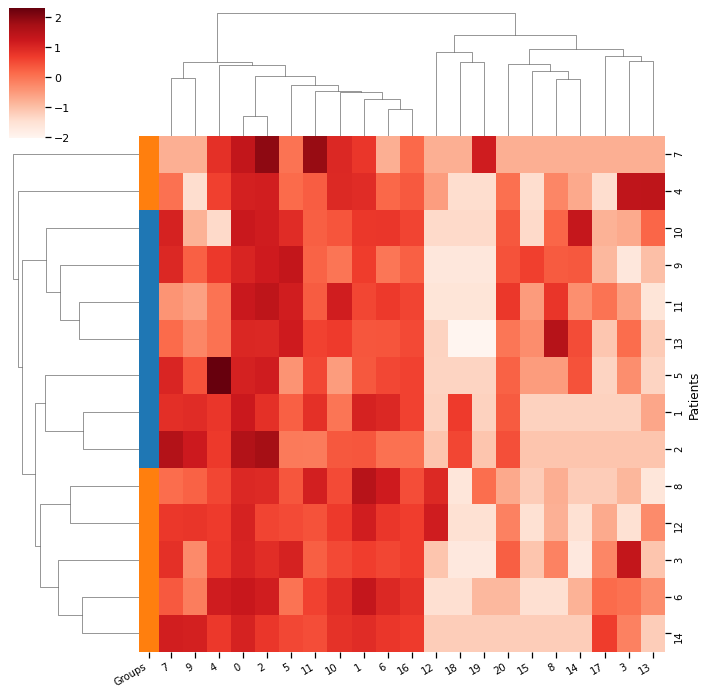

In [142]:
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

# figname = f"resolution-{resolution_parameter}{other_str}_biclustering_normalized-clr.png"
# plt.savefig(cluster_dir / figname)

~~With this more statistically sound way of normalizing data we still obtain a good, although not perfect, blind clustering of patients into responders and non responders.~~

In [143]:
# the colorbar is just wrong
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
s = d.style.background_gradient(cmap=cm)
s

In [144]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [145]:
pvals.head(20)

pval  pval_corr
10  0.053030   0.278409
14  0.053030   0.278409
20  0.053030   0.278409
1   0.053030   0.278409
17  0.212121   0.556818
15  0.212121   0.556818
8   0.212121   0.556818
12  0.212121   0.556818
3   0.575175   0.671037
18  0.575175   0.671037
16  0.575175   0.671037
13  0.575175   0.671037
11  0.575175   0.671037
7   0.575175   0.671037
6   0.575175   0.671037
5   0.575175   0.671037
4   0.575175   0.671037
2   0.575175   0.671037
19  0.962704   0.962704
9   0.962704   0.962704

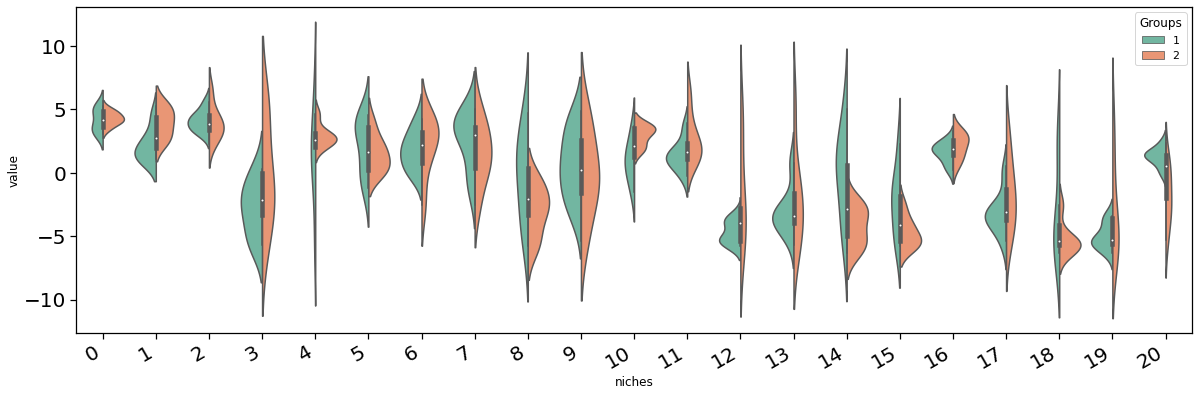

In [146]:
# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

~~From this plot we would like to add niches 4 and 17 to those that segregate patients into groups 1 and 2.~~

In [148]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(coefs.index, coefs)
        plt.xticks(rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")

There is no niche statistically related to response group


##### Elasticnet logistic regression

In [149]:
def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10

In [150]:
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

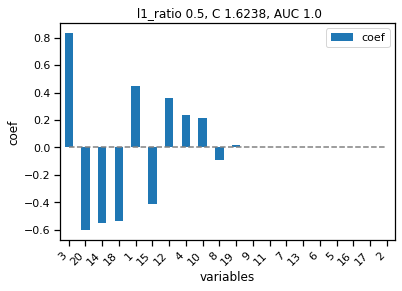

<Figure size 432x288 with 0 Axes>

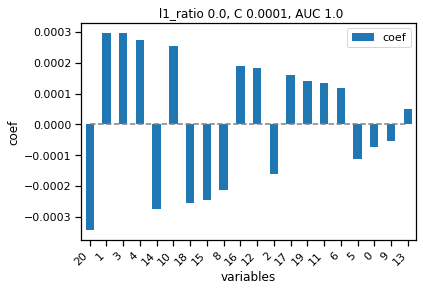

<Figure size 432x288 with 0 Axes>

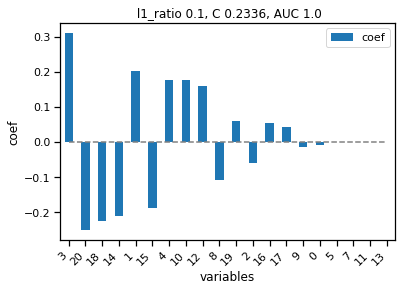

In [151]:
start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

It is quite surprising that the ROC og log reg models are 0.5, whereas we do have statistically different distributions for some variables. To investigate...

In [ ]:
save_dir = cluster_dir / (clusterer_name + "_spatial_networks_figures")
save_dir.mkdir(parents=True, exist_ok=True)

sample_ids = [
    "reg001",
    "reg003",
    "reg005",
    "reg006",
    "reg037",
    "reg040",
    "reg042",
    "reg051",
    "reg054",
    "reg055",
    "reg016",
    "reg058",
    "reg060",
    "reg019",
]

# choose colormap
if nb_clust <= 20:
    clusters_cmap = sns.color_palette('Paired', 20)
    cluster_colors = [clusters_cmap[x] if x >= 0
                      else (0.5, 0.5, 0.5)
                      for x in cluster_labels]
else:
    clusters_cmap = cc.palette["glasbey"]
    # make color mapper
    # series to sort by decreasing order
    uniq = pd.Series(cluster_labels).value_counts().index.astype(int)
    n_colors = len(clusters_cmap)
    labels_color_mapper = {x: clusters_cmap[i % n_colors] for i, x in enumerate(uniq)}
    labels_color_mapper[-1] = (0.5, 0.5, 0.5)
    cluster_colors = np.array([labels_color_mapper[x] for x in cluster_labels])

# colormap for cell-types
n_cell_types = obj['ClusterName'].unique().size
# palette = sns.color_palette(cc.glasbey, n_colors=n_cell_types).as_hex()
palette = [mpl.colors.rgb2hex(x) for x in mpl.cm.get_cmap('tab20').colors]

plots_marker = '.'
for sample in sample_ids:
    print("filename: {}".format(sample))
    select = np.array(obj['FileName'] == sample)

    # load nodes and edges
    coords = obj.loc[select, cell_pos_cols].values
    pairs = edges_all.loc[edges_all['filename'] == sample, ['source', 'target']].values

    # Big summary plot
    fig, ax = plt.subplots(1, 4, figsize=(int(7*4)+1, 7), tight_layout=False)
    i = 0
    ty.plot_network(coords, pairs, labels=obj.loc[select, 'ClusterName'], cmap_nodes=palette, marker=plots_marker, size_nodes=size_points, ax=ax[0])
    ax[i].set_title('Spatial map of phenotypes', fontsize=14);

    i += 1
    ax[i].scatter(coords[:, 0], coords[:, 1], c=cluster_colors[select], marker=plots_marker, s=size_points)
    ax[i].set_title('Spatial map of detected areas', fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[select, 0], embed_viz[select, 1], c=cluster_colors[select], s=5);
    ax[i].set_title("HDBSCAN clustering on NAS", fontsize=14);
    ax[i].set_aspect('equal')

    i += 1
    ax[i].scatter(embed_viz[:, 0], embed_viz[:, 1], c=cluster_colors);
    ax[i].set_title("HDBSCAN clustering on NAS of all samples", fontsize=14);
    ax[i].set_aspect('equal')
    
    # make plot limits equal
    ax[i-1].set_xlim(ax[i].get_xlim())
    ax[i-1].set_ylim(ax[i].get_ylim())

    suptitle = f"Spatial omics data and detected areas - sample {sample}";
    fig.suptitle(suptitle, fontsize=18)

    fig.savefig(save_dir / suptitle, bbox_inches='tight', facecolor='white', dpi=300)

#### Explore different clustering wrt survival

In [ ]:
# for dim_clust in tqdm([2, 3, 4, 5], leave=False):
for dim_clust in tqdm([2], leave=False):
    for n_neighbors in tqdm([15, 45, 75, 100, 200], leave=False):
        for metric in tqdm(['euclidean', 'cosine'], leave=False):
            for k_cluster in tqdm([15, 50], leave=False):
                for resolution_parameter in [0.005, 0.01, 0.05, 0.1, 0.5]:
                    cluster_params = {
                        'reducer_type': 'umap', 
                        'n_neighbors': n_neighbors, 
                        'metric': metric,
                        'min_dist': 0.0,
                        'clusterer_type': 'leiden', 
                        'dim_clust': dim_clust, 
                        'k_cluster': 15, 
                        'resolution_parameter': resolution_parameter,
                    }

                    cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

                    # Survival analysis (just heatmap for now)
                    niches = cluster_labels
                    for normalize in ['total', 'niche', 'obs', 'clr']:
                        counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
                        # merge clinical data and proportion of cells in niches per sample
                        # counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
                        counts_clinic = pd.concat([status, counts], axis=1, join='inner').fillna(0)
                        # counts_clinic.drop(columns=['Spots'], inplace=True)
                        counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()

                        # plot heatmap
                        g, d = mosna.plot_heatmap(
                            counts_clinic.reset_index(), 
                            obs_labels='Patients', 
                            group_var='Groups', 
                            groups=[1, 2],
                            figsize=(10, 10),
                            z_score=False,
                            cmap=sns.color_palette("Reds", as_cmap=True),
                            return_data=True,
                            )
                        # str_params = '_'.join([str(key) + '-' + str(val) for key, val in cluster_params.items()])
                        figname = f"biclustering_resolution-{resolution_parameter}_normalized-{normalize}.png"
                        plt.savefig(cluster_dir / figname, dpi=150)

## Final parameters

Perfect separation:
```
reducer-umap_dim-2_nneigh-45_metric-cosine_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.1_normalized-clr  
reducer-umap_dim-2_nneigh-45_metric-cosine_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.05_normalized-clr
```
1 error separation:
```
reducer-umap_dim-2_nneigh-45_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.1_normalized-niche  
reducer-umap_dim-2_nneigh-100_metric-euclidean_min_dist-0.0/clusterer-leiden_n_neighbors-15/biclustering_resolution-0.005_normalized-clr
```

In [64]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 45, 
    'metric': 'cosine', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.1,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 22 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

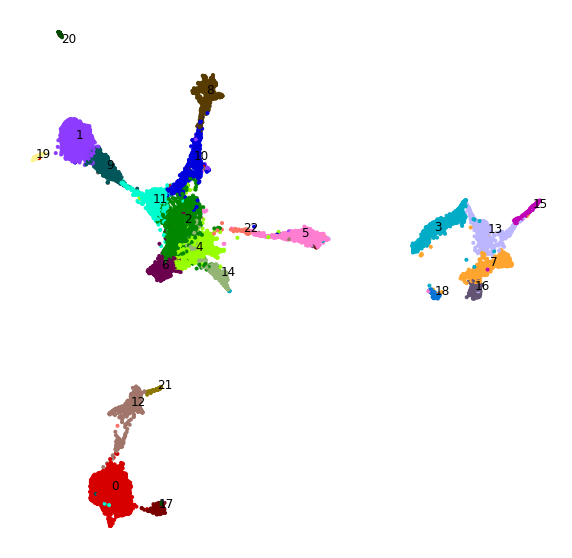

In [65]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

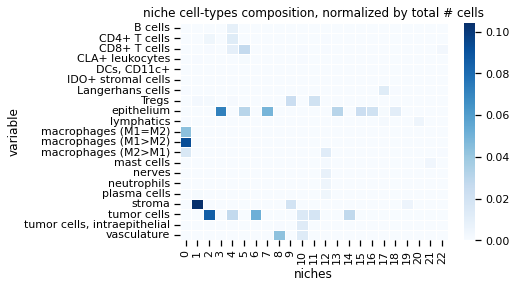

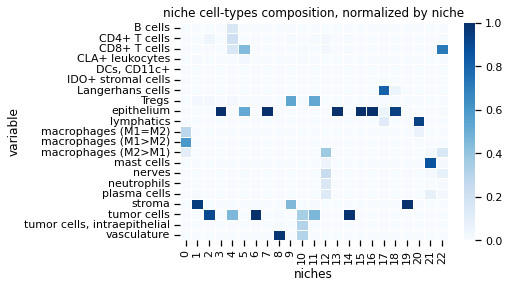

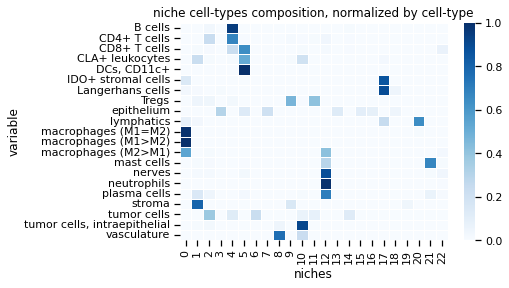

In [66]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

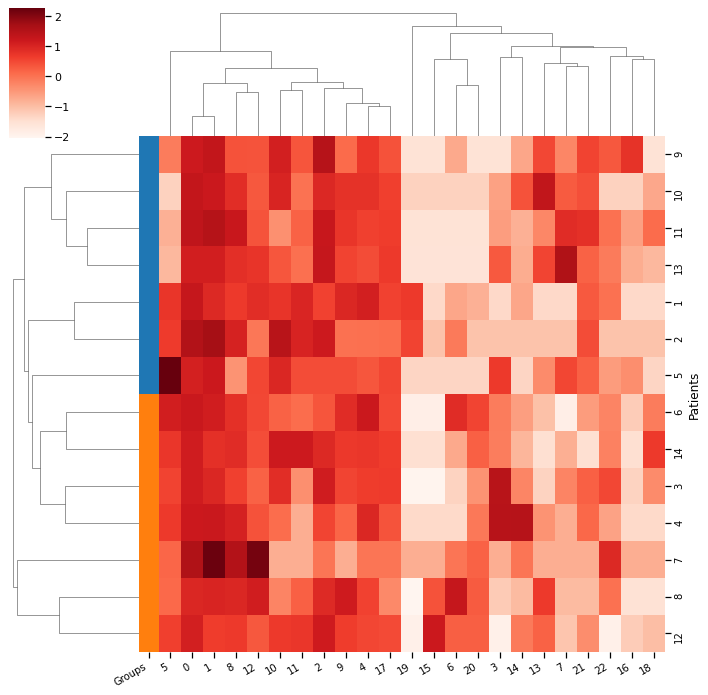

In [67]:
other_str = ''
# proportion of cells in niches per sample, normalized with Central Log Ratio
normalize = 'clr'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-{normalize}.png"
plt.savefig(cluster_dir / figname)

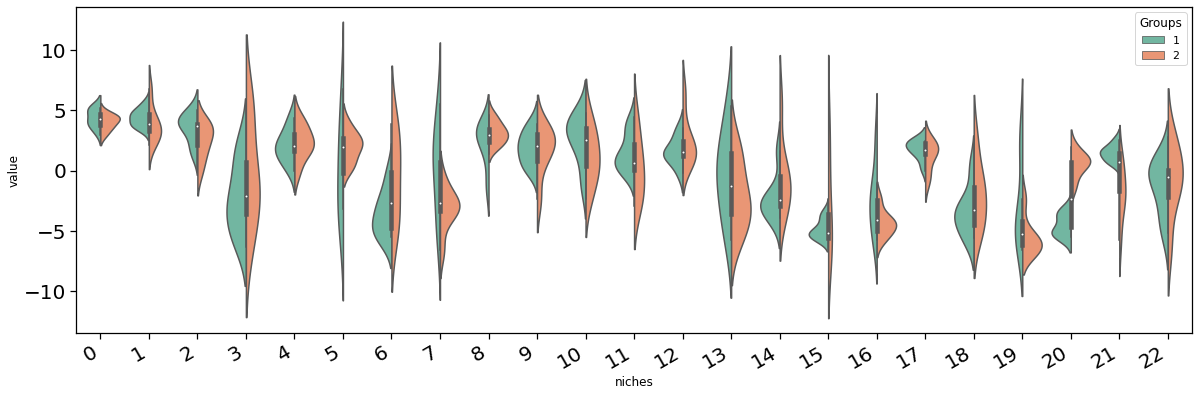

In [68]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                              20 with p-value 6.86496e-07
Add                              19 with p-value 0.0177576


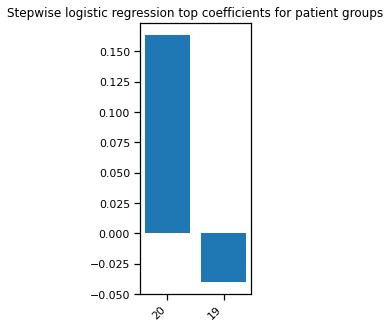

In [69]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

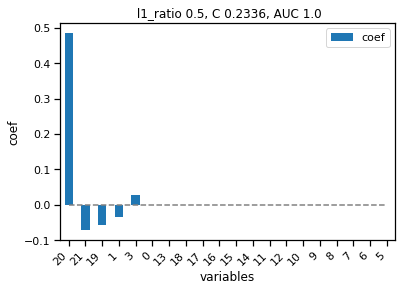

<Figure size 432x288 with 0 Axes>

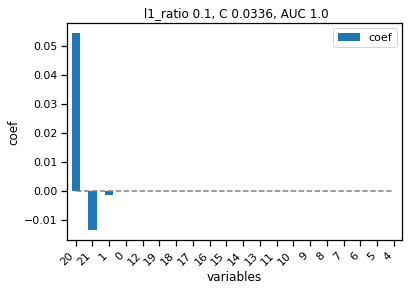

<Figure size 432x288 with 0 Axes>

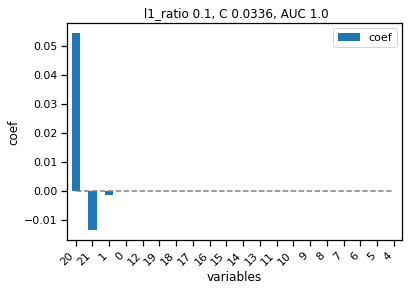

In [70]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

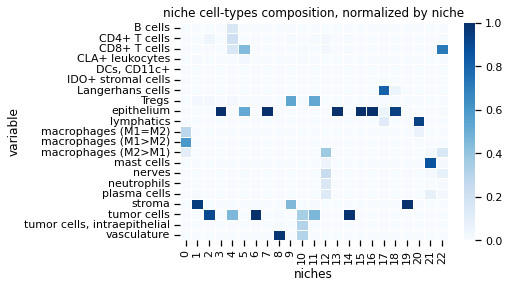

In [71]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

Ok, it might be interesting, although quite not sure

In [72]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 45, 
    'metric': 'cosine', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.05,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 19 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

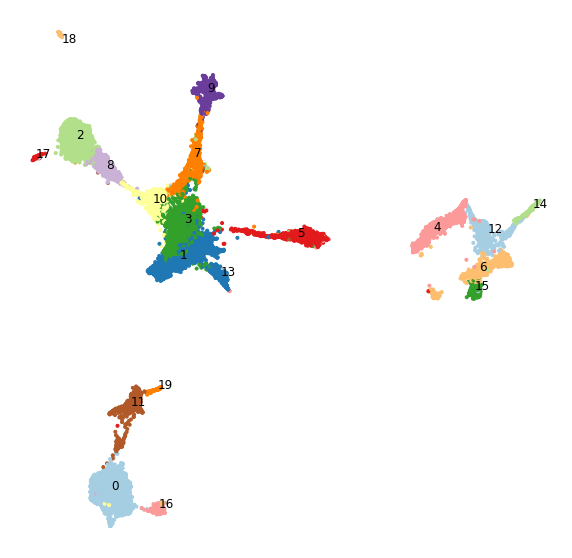

In [73]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

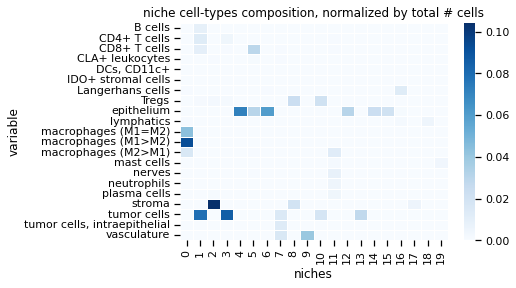

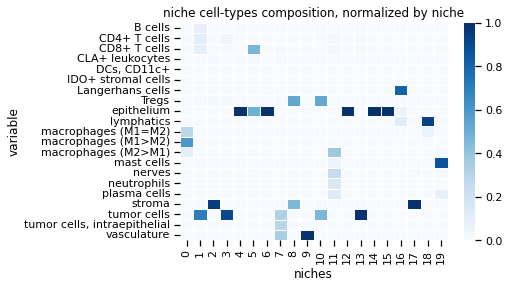

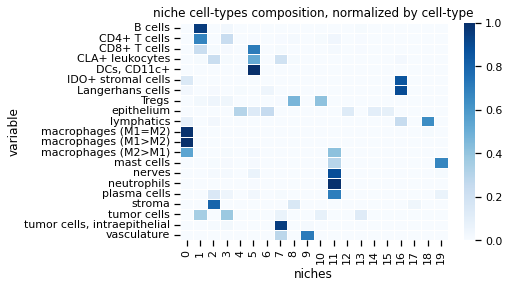

In [74]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

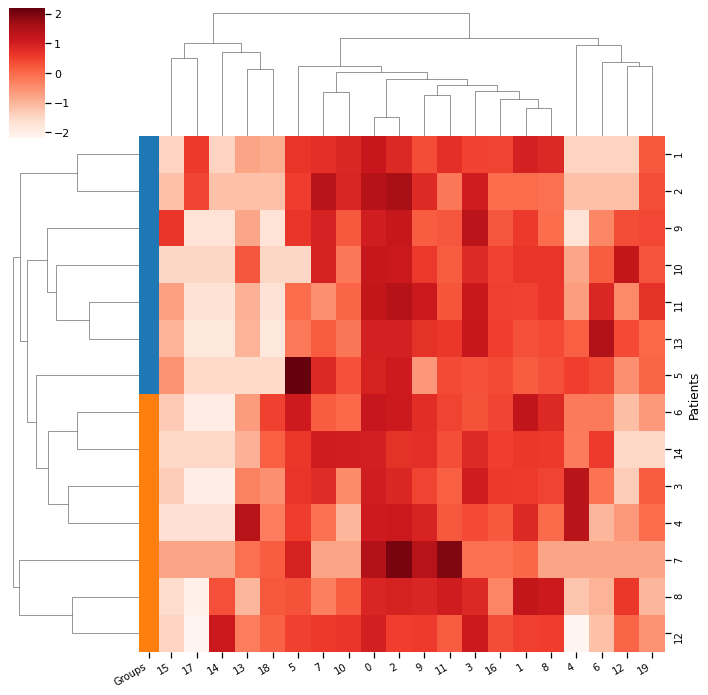

In [75]:
other_str = ''
# proportion of cells in niches per sample, normalized with Central Log Ratio
normalize = 'clr'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-{normalize}.png"
plt.savefig(cluster_dir / figname)

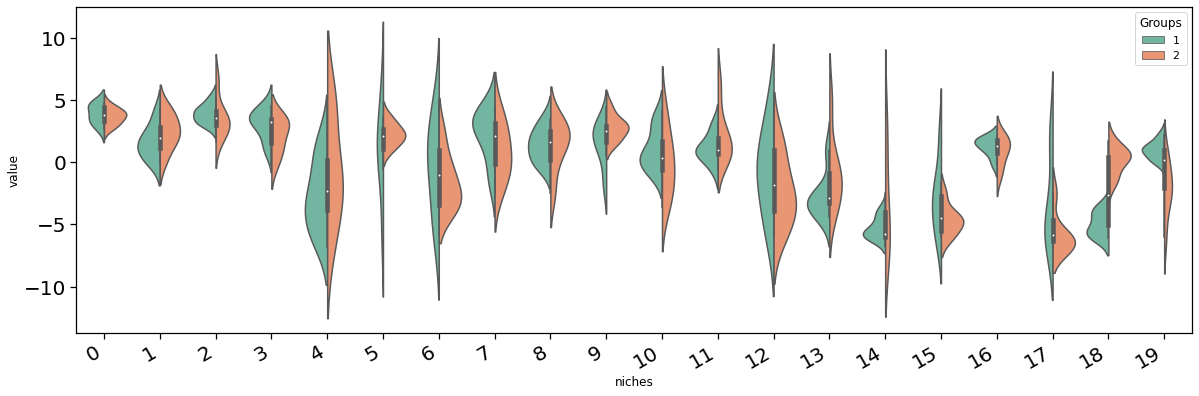

In [76]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                              18 with p-value 1.03793e-06
Add                              17 with p-value 0.0136162
Add                              13 with p-value 0.0367295


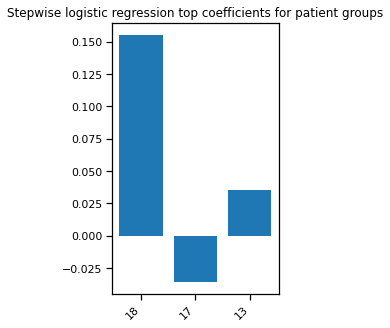

In [77]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

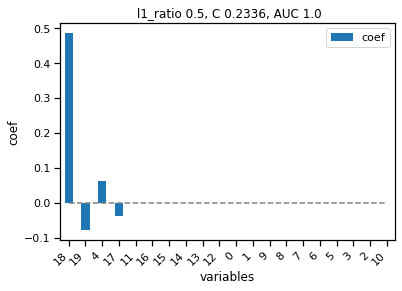

<Figure size 432x288 with 0 Axes>

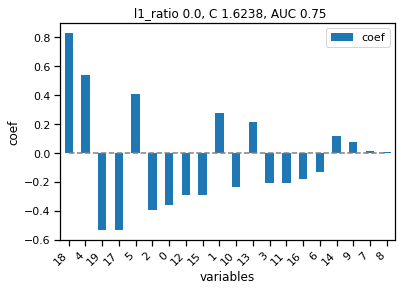

<Figure size 432x288 with 0 Axes>

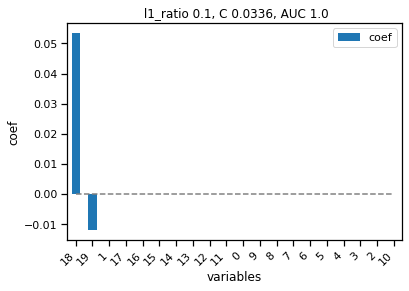

In [78]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

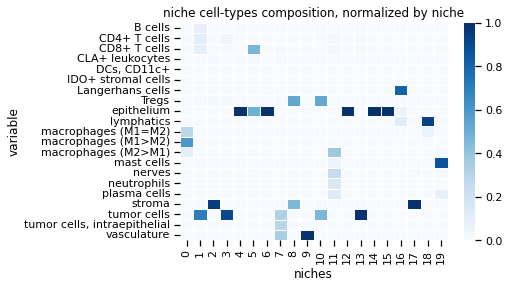

In [79]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

The most interesting niches, 0, 1, 7 and 11, are not predictive of response to immunotherapy in this case.  
The predictive niches are 18 and 19, that have *some* interactions, and 4 and 17, that are pure niches.

In [80]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 45, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.1,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 23 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

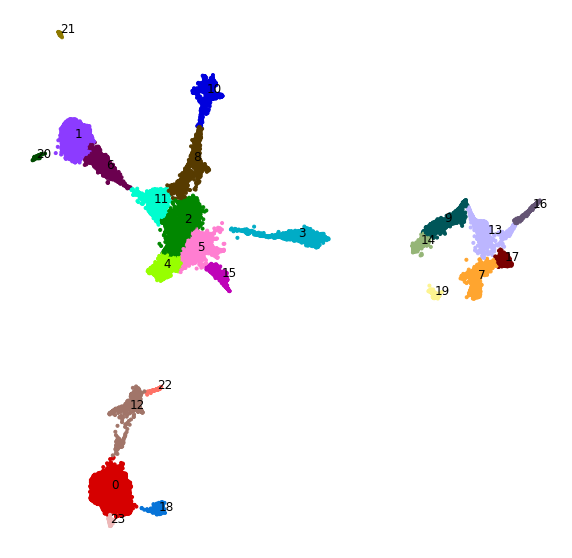

In [81]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

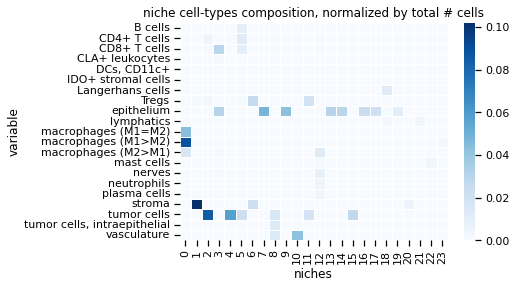

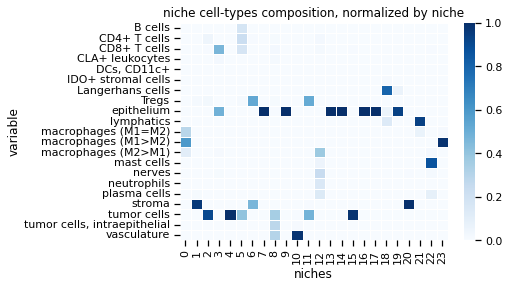

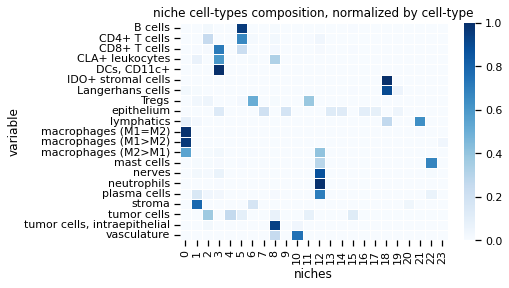

In [82]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

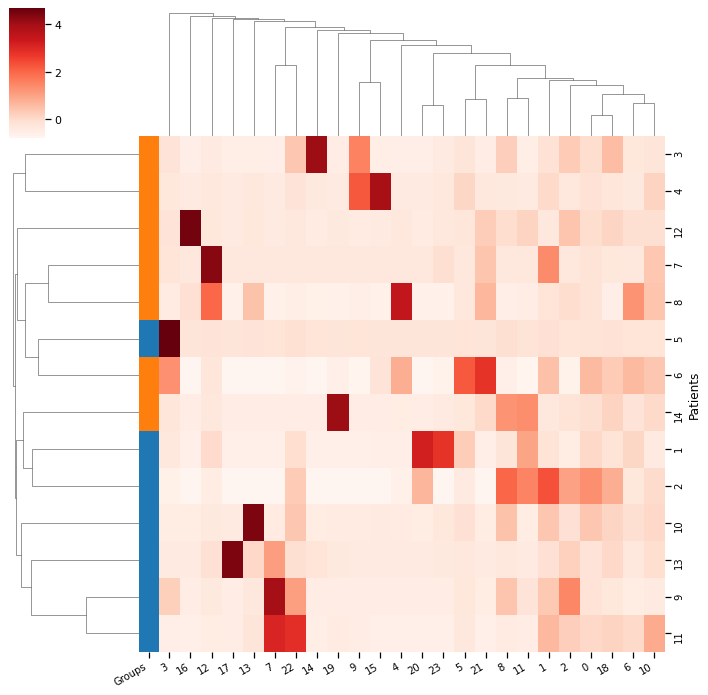

In [84]:
other_str = ''
# proportion of cells in niches per sample, normalized by niche
normalize = 'niche'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-{normalize}.png"
plt.savefig(cluster_dir / figname)

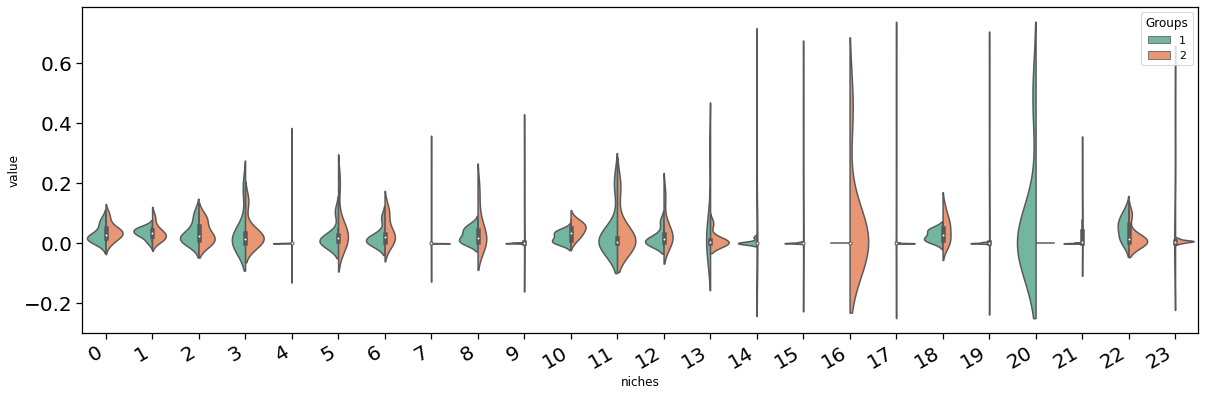

In [85]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                              10 with p-value 0.0364824


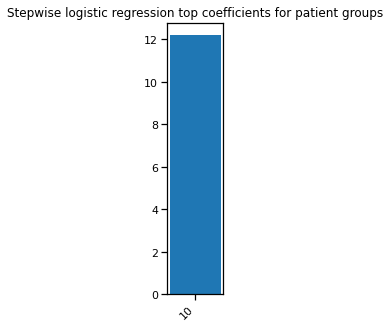

In [86]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

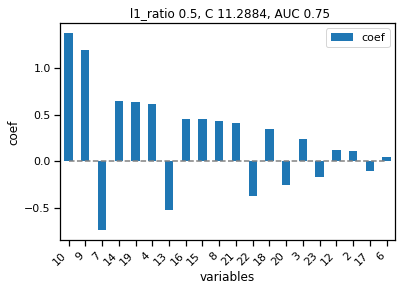

<Figure size 432x288 with 0 Axes>

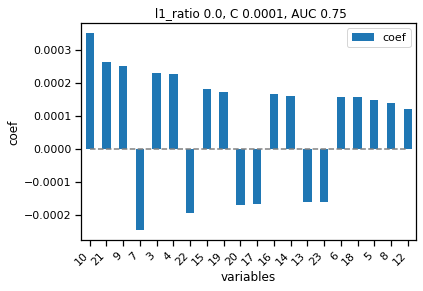

<Figure size 432x288 with 0 Axes>

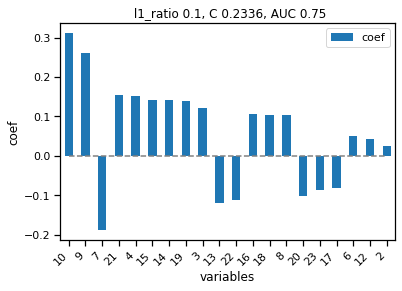

In [87]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

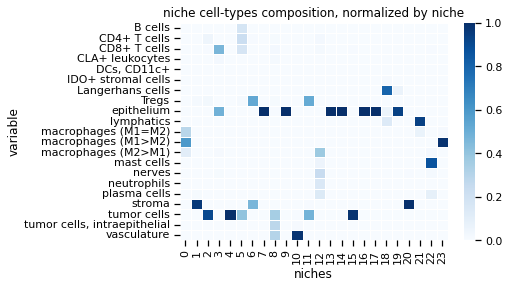

In [88]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

Only pure niches

In [89]:
cluster_params = {
    'reducer_type': 'umap', 
    'n_neighbors': 100, 
    'metric': 'euclidean', 
    'min_dist': 0.0,
    'clusterer_type': 'leiden', 
    'dim_clust': 2, 
    'k_cluster': 15, 
    'resolution_parameter': 0.005,
}

cluster_labels, cluster_dir, nb_clust, _ = mosna.get_clusterer(var_aggreg, nas_dir, **cluster_params)

Loading clusterer object and cluster labels
There are 8 clusters


Loading reducer object and reduced coordinates


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

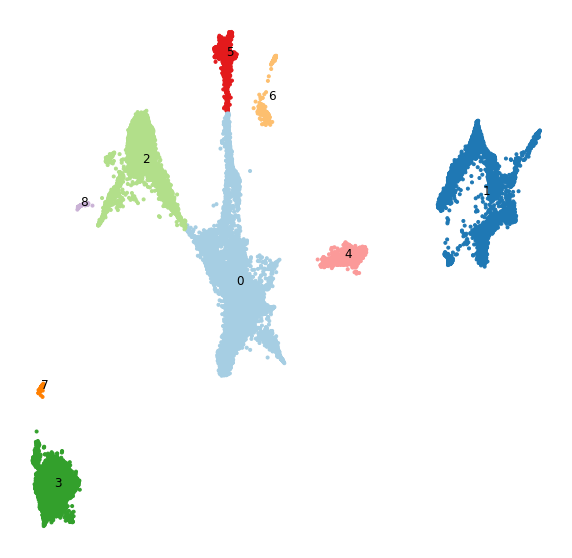

In [90]:
embed_viz, _ = mosna.get_reducer(var_aggreg, nas_dir, reducer_type='umap', n_neighbors=cluster_params['n_neighbors'])
mosna.plot_clusters(embed_viz, cluster_labels, nas_dir, cluster_params=cluster_params)

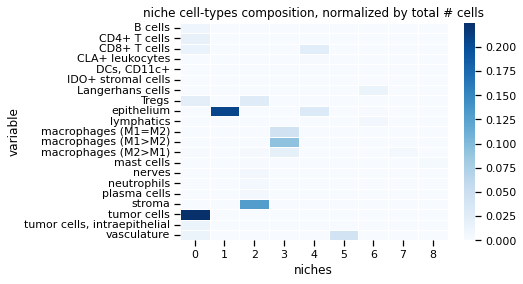

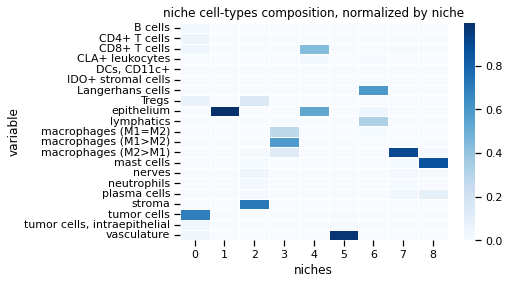

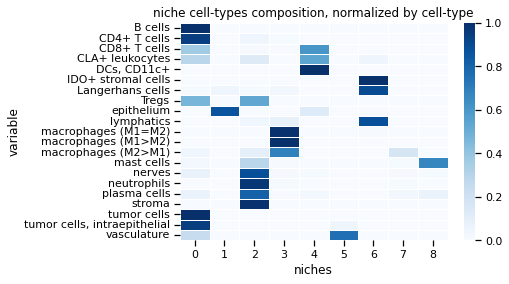

In [91]:
# Survival analysis

cell_types = nodes_all['CellCluster']
niches = cluster_labels

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types')
title = "niche cell-types composition, normalized by total # cells"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
title = "niche cell-types composition, normalized by niche"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='obs')
title = "niche cell-types composition, normalized by cell-type"
plt.title(title)
plt.savefig(cluster_dir / title, bbox_inches='tight', facecolor='white')

I think the resolution is too low and we can't even compare pure niches vs cosmopolite niches.

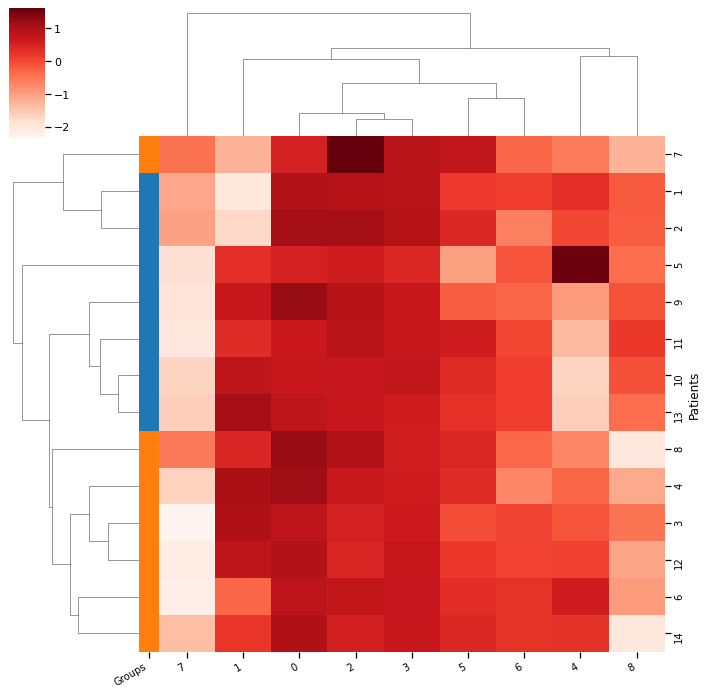

In [92]:
# proportion of cells in niches per sample, normalized with Central Log Ratio
normalize = 'clr'
counts = mosna.make_niches_composition(obj['FileName'], niches, var_label='variable', normalize=normalize)
# merge clinical data and proportion of cells in niches per sample
counts_clinic = pd.concat([status, counts], axis=1, join='inner').sort_values('Spots').fillna(0)
counts_clinic.drop(columns=['Spots'], inplace=True)
counts_clinic = counts_clinic.groupby(['Patients', 'Groups']).mean()
# heatmap
g, d =mosna.plot_heatmap(
    counts_clinic.reset_index(), 
    obs_labels='Patients', 
    group_var='Groups', 
    groups=[1, 2],
    figsize=(10, 10),
    z_score=False,
    cmap=sns.color_palette("Reds", as_cmap=True),
    return_data=True,
    )

figname = f"resolution-{cluster_params['resolution_parameter']}{other_str}_biclustering_normalized-{normalize}.png"
plt.savefig(cluster_dir / figname)

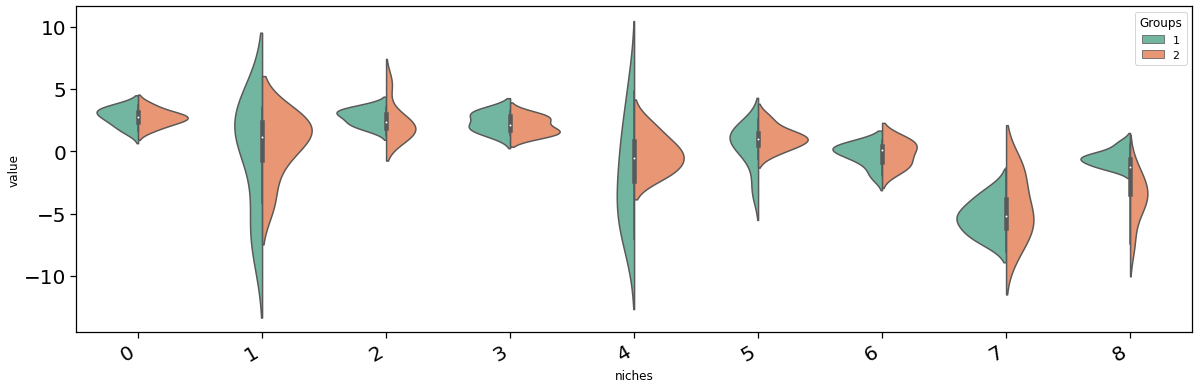

In [93]:
pvals = mosna.find_DE_markers(counts_clinic, group_ref=2, group_tgt=1, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

# DE analysis
fig, ax = mosna.plot_distrib_groups(
    counts_clinic, 
    group_var='Groups',
    groups=[1, 2], 
    pval_data=None,
    multi_ind_to_col=True,
    var_name='niches',
    )

Add                               8 with p-value 0.00112146


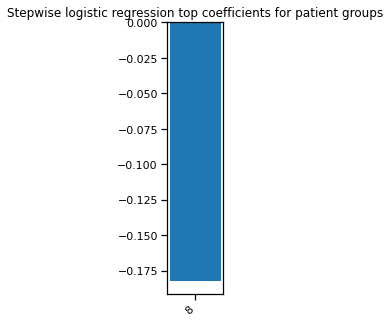

In [94]:
# Stepwise logistic regression
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
if len(best_pval_names) > 0:
    model, included = mosna.stepwise_regression(X=counts_clinic, y_name='Groups', y_values=[1, 2], verbose=True)

    # plot the model's coefficients
    coefs = model.params[1:] # skip intercept
    nb_coefs = min(coefs.size, 20)
    if nb_coefs > 0:
        fig, ax = plt.subplots(figsize=(nb_coefs,5))
        ax.bar(range(len(coefs.index)), coefs)
        plt.xticks(ticks=range(len(coefs.index)), labels=coefs.index, rotation=45, ha='right');
        title = f"Stepwise logistic regression top coefficients for patient groups"
        plt.title(title)
else:
    print("There is no niche statistically related to response group")







-------------------------------------------
------------------- END -------------------
-------------------------------------------
Training took {duration}s


<Figure size 432x288 with 0 Axes>

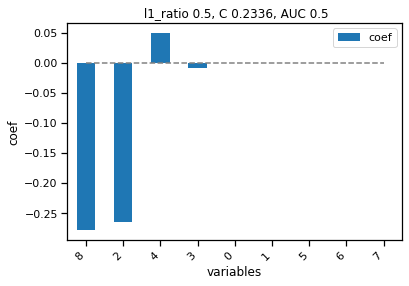

<Figure size 432x288 with 0 Axes>

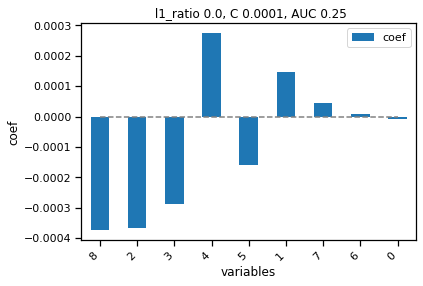

<Figure size 432x288 with 0 Axes>

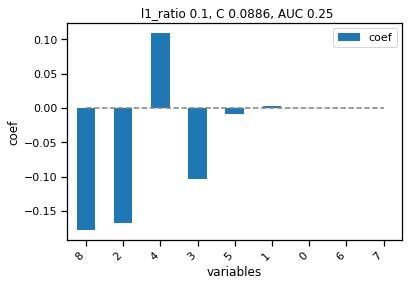

In [95]:
# Elasticnet logistic regression

def write_log(file, message):
    print(message)
    file.write(message + '\n')

# l1_ratio = 0 the penalty is an L2 penalty [Ridge]
# l1_ratio = 1 the penalty is an L1 penalty (Lasso)

# Test either one of those combinations
l1_ratios_list = [
    ['default', [0.5]],
    ['naive', np.linspace(0, 1, 21)],           # naive param grid
    ['advised', [.1, .5, .7, .9, .95, .99, 1]], # advised in scikit-learn documentation
]

score_labels = [
    'ROC AUC', # Receiver Operating Characteristic Area Under the Curve
    'AP',      # Average Precision
    'MCC',     # Matthews Correlation Coefficient
]
CV_TRAIN = 5
CV_ADAPT = True
CV_MAX = 10


# /!\ not related to `X = obj[aggreg_vars].values`
X = counts_clinic.reset_index()
X = X.loc[(X.loc[:, 'Groups'] == 1) | (X.loc[:, 'Groups'] == 2), :]
y = X['Groups'].values - 1  # to have resp=0, non-resp=1
var_idx = X.iloc[:, 2:].columns
X = X.iloc[:, 2:]

start = time()

for l1_name, l1_ratios in l1_ratios_list:
    dir_save = cluster_dir / "logistic_regression" / f'l1_ratios-{l1_name}'
    dir_save.mkdir(parents=True, exist_ok=True)
    log_file = open(dir_save / "training_logs.txt","a")

    score_split = {}
    # stratify train / test by response
    np.random.seed(0)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.25, 
        random_state=0, 
        shuffle=True, 
    )
    # Standardize data to give same weight to regularization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    training_succeeded = False
    cv_used = CV_TRAIN
    while not training_succeeded and cv_used <= CV_MAX:
        np.random.seed(0)
        clf = linear_model.LogisticRegressionCV(
            cv=cv_used,
            Cs=20, 
            penalty='elasticnet', 
            # scoring='neg_log_loss', 
            scoring='roc_auc', 
            solver='saga', 
            l1_ratios=l1_ratios,
            max_iter=10000,
            n_jobs=-1,  # or n_jobs-1 to leave one core available
        )
        clf = clf.fit(X_train, y_train)
        training_succeeded = not np.all(clf.coef_ == 0)
        if not training_succeeded:
            if CV_ADAPT:
                cv_used += 1
                print("        training failed, trying with cv = {cv_used}")
            else:
                print("        training failed")
                break
        
    if training_succeeded:
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
        score = {
            'ROC AUC': metrics.roc_auc_score(y_test, y_pred_proba),
            'AP' : metrics.average_precision_score(y_test, y_pred_proba),
            'MCC': metrics.matthews_corrcoef(y_test, y_pred),
        }

        # Save model coefficients and plots
        l1_ratio = np.round(clf.l1_ratio_[0], decimals=4)
        C = np.round(clf.C_[0], decimals=4)

        coef = pd.DataFrame({'coef': clf.coef_.flatten()}, index=var_idx)
        coef['abs coef'] = coef['coef'].abs()
        coef = coef.sort_values(by='abs coef', ascending=False)
        coef['% total'] = coef['abs coef'] / coef['abs coef'].sum()
        coef['cum % total'] = coef['% total'].cumsum()
        coef['coef OR'] = np.exp(coef['coef'])
        coef.to_csv(dir_save / f"LogisticRegressionCV_coefficients.csv")
        nb_coef = coef.shape[0]
        
        nb_coef_plot = min(20, nb_coef)
        labels = coef.index[:nb_coef_plot]

        plt.figure()
        ax = coef.loc[labels, 'coef'].to_frame().plot.bar()
        ax.hlines(y=0, xmin=0, xmax=nb_coef_plot-1, colors='gray', linestyles='dashed')
        ticks_pos = np.linspace(start=0, stop=nb_coef_plot-1, num=nb_coef_plot)
        # ticks_label = np.round(ticks_label, decimals=2)
        ax.set_xticks(ticks_pos);
        # ax.set_xticklabels(ticks_label)
        ax.set_xticklabels(labels, rotation=45, ha='right');
        plt.xlabel('variables')
        plt.ylabel('coef')
        plt.title(f" l1_ratio {l1_ratio}, C {C}, AUC {score['ROC AUC']}")
        plt.savefig(dir_save / f"coef.png", bbox_inches='tight', facecolor='white')

    else:
        score = {
            'ROC AUC': np.nan,
            'AP' : np.nan,
            'MCC': np.nan,
        }
        print("        training failed with cv <= {CV_MAX}")
            
    # plt.show()

    scores = pd.DataFrame.from_dict(score, orient='index')
    scores.to_csv(dir_save / 'scores_niches.csv')

end = time()
duration = end - start
print("\n"*5)
print("-------------------------------------------")
print("------------------- END -------------------")
print("-------------------------------------------")
print("Training took {duration}s")
log_file.close()

Text(0.5, 1.0, 'niche cell-types composition, normalized by niche')

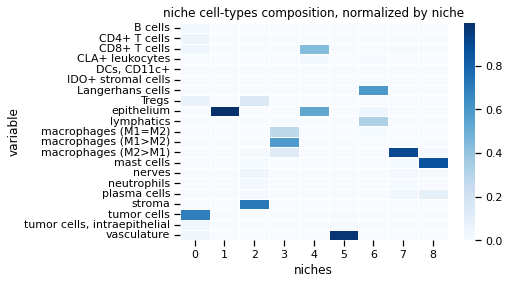

In [96]:
# as a reminder:
mosna.plot_niches_composition(var=cell_types, niches=niches, var_label='cell-types', normalize='niche')
plt.title("niche cell-types composition, normalized by niche")

The clustering resolution is I think too low to draw conclusions, even though there is good separation of patients per response.